In [2]:
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
pd.set_option("display.max_rows", 300)

In [3]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"

LLMS = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]
AUTHORS = LLMS + [HUMAN]

REDDIT = "reddit"
HEWLETT = "hewlett"
DATASETS = [REDDIT, HEWLETT]

# Function words

In [4]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    fw_oseah = [line.split()[0] for line in lines]

# Z-Scores

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer


class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, fw):
        self.fw = fw
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # Save the function words and their indicies if they are in the vocabulary
        self.used_fw = [word for word in self.fw if word in self.vectorizer.vocabulary_]
        self.used_fw_indices = [
            self.vectorizer.vocabulary_[word] for word in self.used_fw
        ]

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)[:, self.used_fw_indices]

        return z_scores

    def get_used_fw(self):
        return self.used_fw

# Deltas

In [6]:
def delta(z_scores, variant):
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

# Classification pipeline

In [7]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os


def classify(
    df,
    function_words,
    test_prompts=None,
    return_df_coefs=False,
    df_test_include_text=False,
):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    if not test_prompts:
        test_prompts = random.sample(prompt_ids, 2)

    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    df_test["author_pred"] = y_pred
    if not df_test_include_text:
        df_test = df_test.drop(columns=["text"])

    # print the words that were most important for the model
    if return_df_coefs:
        coefs = model.best_estimator_.coef_.squeeze()
        used_fw = z_scores_transformer.get_used_fw()
        df_coefs = pd.DataFrame({"word": used_fw, "coef": coefs})
        return df_test, df_coefs

    else:
        return df_test

In [8]:
################## CLASSIFY TEST ##################


# df_human = pd.read_csv(f"{REDDIT}/responses/{HUMAN}.csv")
# df_human["author"] = HUMAN
# df_llm = pd.read_csv(f"{REDDIT}/responses/{GPT_35}.csv")
# df_llm["author"] = GPT_35
# df = pd.concat([df_human, df_llm]).reset_index(drop=True)

# df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

# Binary classification (1 LLM vs human)

In [9]:
N_TRIALS = 30
fw = fw_oseah

if not os.path.exists("results/binary_classification.csv"):
    binary_classification = []
    for dataset in DATASETS:
        df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
        df_human["author"] = HUMAN
        for llm in LLMS:
            df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
            df_llm["author"] = llm
            df = pd.concat([df_human, df_llm], ignore_index=True)
            for trial in tqdm(range(N_TRIALS), desc=f"{dataset} {llm}"):
                df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

                binary_classification.append(
                    {
                        "dataset": dataset,
                        "llm": llm,
                        "trial": trial,
                        "df_test": df_test.to_json(orient="records"),
                        "df_coefs": df_coefs.to_json(orient="records"),
                    }
                )

    df_binary_classification = pd.DataFrame(binary_classification)
    df_binary_classification.to_csv(f"results/binary_classification.csv", index=False)

  dataset                       llm  accuracy  family
0  reddit    claude-3-opus-20240229  0.837333  claude
1  reddit  claude-3-sonnet-20240229  0.853250  claude
2  reddit            gemini-1.0-pro  0.940417  gemini
3  reddit     gemini-1.5-pro-latest  0.903750  gemini
4  reddit        gpt-3.5-turbo-0125  0.907333     gpt
5  reddit    gpt-4-turbo-2024-04-09  0.932417     gpt


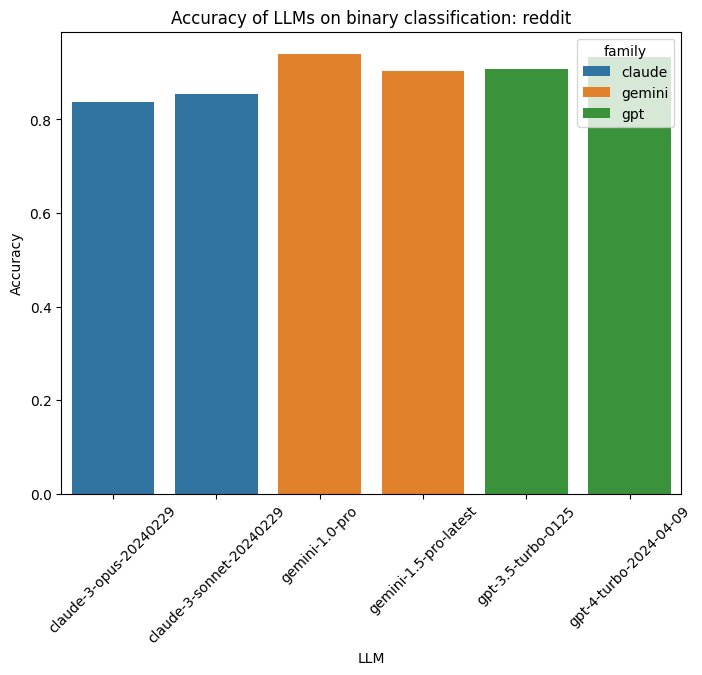

   dataset                       llm  accuracy  family
0  hewlett    claude-3-opus-20240229  0.861583  claude
1  hewlett  claude-3-sonnet-20240229  0.835083  claude
2  hewlett            gemini-1.0-pro  0.917167  gemini
3  hewlett     gemini-1.5-pro-latest  0.927417  gemini
4  hewlett        gpt-3.5-turbo-0125  0.942833     gpt
5  hewlett    gpt-4-turbo-2024-04-09  0.949917     gpt


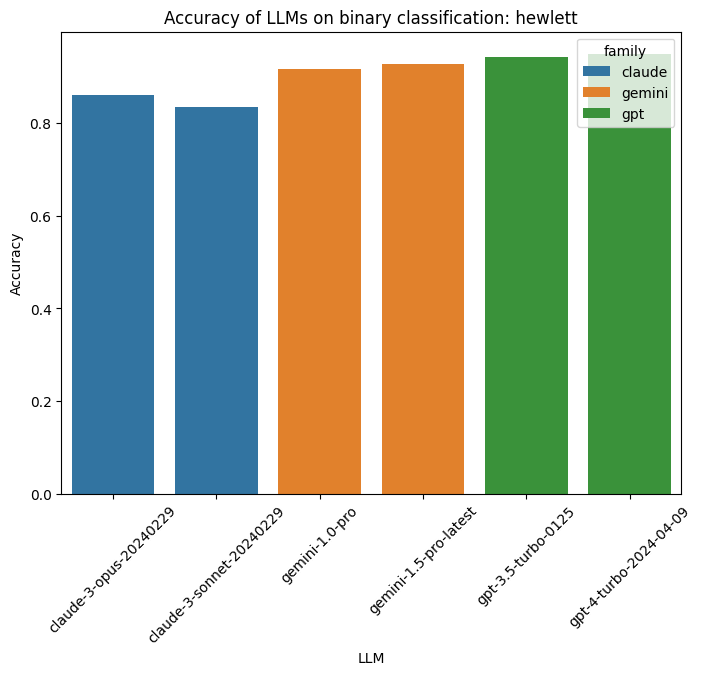

In [10]:
from io import StringIO


df_bin = pd.read_csv("results/binary_classification.csv")
for dataset in DATASETS:
    df_bin_dataset = df_bin[df_bin["dataset"] == dataset]
    df_acc = []
    for _, dataset, llm, _, df_test, _ in df_bin_dataset.itertuples():
        df_test = pd.read_json(StringIO(df_test), orient="records")
        acc = (df_test["author"] == df_test["author_pred"]).mean()
        df_acc.append({"dataset": dataset, "llm": llm, "accuracy": acc})
    df_acc = pd.DataFrame(df_acc)
    df_acc = df_acc.groupby(["dataset", "llm"]).mean().reset_index()
    df_acc["family"] = df_acc["llm"].apply(lambda x: x.split("-")[0])
    print(df_acc)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_acc, x="llm", y="accuracy", hue="family")
    plt.title(f"Accuracy of LLMs on binary classification: {dataset}")
    plt.ylabel("Accuracy")
    plt.xlabel("LLM")
    plt.xticks(rotation=45)
    plt.show()

## Most important words

For each LLM and dataset, rank the words by their coefficient in the LR model (rankings are averaged over N_TRIALS trials).

In [11]:
from io import StringIO


N = 10
fw = fw_oseah

df_binary_classification = pd.read_csv("results/binary_classification.csv")

df_coefs_list = []
for _, dataset, llm, _, _, df_coefs in df_binary_classification.itertuples():
    df_coefs = pd.read_json(StringIO(df_coefs))
    df_coefs["dataset"] = dataset
    df_coefs["llm"] = llm
    df_coefs["coef_abs"] = np.abs(df_coefs["coef"])
    df_coefs["coef_sign"] = np.sign(df_coefs["coef"])

    # Add a row for each word that is in fw but not in the df
    fw_used = set(df_coefs["word"].values)
    new_rows = []
    for word in fw:
        if word not in fw_used:
            new_rows.append(
                {
                    "dataset": dataset,
                    "llm": llm,
                    "word": word,
                    "coef_abs": 0,
                    "coef_sign": 0,
                }
            )

    df_new_rows = pd.DataFrame(new_rows)
    df_coefs = pd.concat([df_coefs, df_new_rows], ignore_index=True)

    # Compute ranks (use average rank for ties)
    df_coefs["rank"] = df_coefs.groupby(["dataset", "llm"])["coef_abs"].rank(
        method="average", ascending=False
    )
    df_coefs_list.append(df_coefs)

df_coefs = pd.concat(df_coefs_list, ignore_index=True)
df_avg_ranks = df_coefs.groupby(["dataset", "llm", "word"]).mean().reset_index()
df_n_smallest = df_avg_ranks.groupby(["dataset", "llm"]).apply(
    lambda x: x.nsmallest(N, "rank"), include_groups=False
)
df_n_smallest = df_n_smallest.reset_index()
df_n_smallest = df_n_smallest.drop(columns=["level_2", "coef_abs", "coef_sign"])
df_n_smallest = df_n_smallest.rename(columns={"rank": "avg_rank", "coef": "avg_coef"})

# Calculate odds ratio
df_n_smallest["odds_ratio"] = df_n_smallest["avg_coef"].apply(np.exp)

print(
    f"A positive coefficient/large odd ratio means the word is associated with human writing."
)

df_n_smallest

A positive coefficient/large odd ratio means the word is associated with human writing.


dataset                       llm         word  avg_coef   avg_rank  \
0    hewlett    claude-3-opus-20240229      because  0.320899   1.133333   
1    hewlett    claude-3-opus-20240229          was  0.258828   5.400000   
2    hewlett    claude-3-opus-20240229          and -0.258058   5.600000   
3    hewlett    claude-3-opus-20240229           is  0.266424   6.633333   
4    hewlett    claude-3-opus-20240229     moreover -0.241432   8.400000   
5    hewlett    claude-3-opus-20240229      despite -0.231174   8.933333   
6    hewlett    claude-3-opus-20240229         this  0.227098  11.500000   
7    hewlett    claude-3-opus-20240229           so  0.230812  11.633333   
8    hewlett    claude-3-opus-20240229         they  0.204929  12.666667   
9    hewlett    claude-3-opus-20240229          all  0.208139  13.100000   
10   hewlett  claude-3-sonnet-20240229      because  0.328370   2.333333   
11   hewlett  claude-3-sonnet-20240229          and -0.320535   3.033333   
12   hewlett  claude-3-sonnet-20240229           is  0.292764   5.166667   
13   hewlett  claude-3-sonnet-20240229          was  0.294421   7.033333   
14   hewlett  claude-3-sonnet-20240229      despite -0.266001   9.033333   
15   hewlett  claude-3-sonnet-20240229           as -0.250998  10.333333   
16   hewlett  claude-3-sonnet-20240229         here -0.278957  10.966667   
17   hewlett  claude-3-sonnet-20240229         this  0.224105  13.833333   
18   hewlett  claude-3-sonnet-20240229      several -0.231581  13.933333   
19   hewlett  claude-3-sonnet-20240229         they  0.218467  13.966667   
20   hewlett            gemini-1.0-pro      because  0.275409   1.866667   
21   hewlett            gemini-1.0-pro          was  0.243452   3.700000   
22   hewlett            gemini-1.0-pro           of -0.242634   3.800000   
23   hewlett            gemini-1.0-pro          all  0.204325   8.033333   
24   hewlett            gemini-1.0-pro          and -0.214936   8.033333   
25   hewlett            gemini-1.0-pro         many  0.207117   8.266667   
26   hewlett            gemini-1.0-pro          how  0.202036   8.500000   
27   hewlett            gemini-1.0-pro         this  0.199591   9.266667   
28   hewlett            gemini-1.0-pro           as -0.193697  10.566667   
29   hewlett            gemini-1.0-pro           so  0.171841  12.900000   
30   hewlett     gemini-1.5-pro-latest           is  0.239218   1.566667   
31   hewlett     gemini-1.5-pro-latest      because  0.244786   1.900000   
32   hewlett     gemini-1.5-pro-latest         when  0.173962   7.833333   
33   hewlett     gemini-1.5-pro-latest          was  0.187542  10.000000   
34   hewlett     gemini-1.5-pro-latest        there  0.173982  10.400000   
35   hewlett     gemini-1.5-pro-latest         this  0.166831  12.000000   
36   hewlett     gemini-1.5-pro-latest           so  0.153623  14.900000   
37   hewlett     gemini-1.5-pro-latest      further -0.150666  15.100000   
38   hewlett     gemini-1.5-pro-latest          all  0.153883  16.033333   
39   hewlett     gemini-1.5-pro-latest          and -0.157682  17.066667   
40   hewlett        gpt-3.5-turbo-0125  furthermore -0.250748   2.800000   
41   hewlett        gpt-3.5-turbo-0125          and -0.214574   3.300000   
42   hewlett        gpt-3.5-turbo-0125      despite -0.216348   3.500000   
43   hewlett        gpt-3.5-turbo-0125           of -0.192872   4.266667   
44   hewlett        gpt-3.5-turbo-0125           is  0.189925   5.133333   
45   hewlett        gpt-3.5-turbo-0125           as -0.176259   6.366667   
46   hewlett        gpt-3.5-turbo-0125      because  0.166101   7.200000   
47   hewlett        gpt-3.5-turbo-0125     moreover -0.180463   9.000000   
48   hewlett        gpt-3.5-turbo-0125         this  0.158821  10.566667   
49   hewlett        gpt-3.5-turbo-0125          was  0.155999  11.066667   
50   hewlett    gpt-4-turbo-2024-04-09     moreover -0.133403   2.533333   
51   hewlett    gpt-4-turbo-2024-04-09      because  

## Word frequencies

### Ratios

In [12]:
# get the 10 words with the smallest average rank across all datasets and llms
N = 10
df_coefs_mult = df_coefs.copy()
n_most_important = (
    df_coefs[["word", "rank"]].groupby("word").mean().sort_values("rank").head(10)
)
n_most_important

rank
word              
was      20.738889
it       27.969444
a        30.863889
of       31.477778
as       33.419444
is       34.308333
and      35.283333
he       37.533333
because  38.863889
all      44.355556

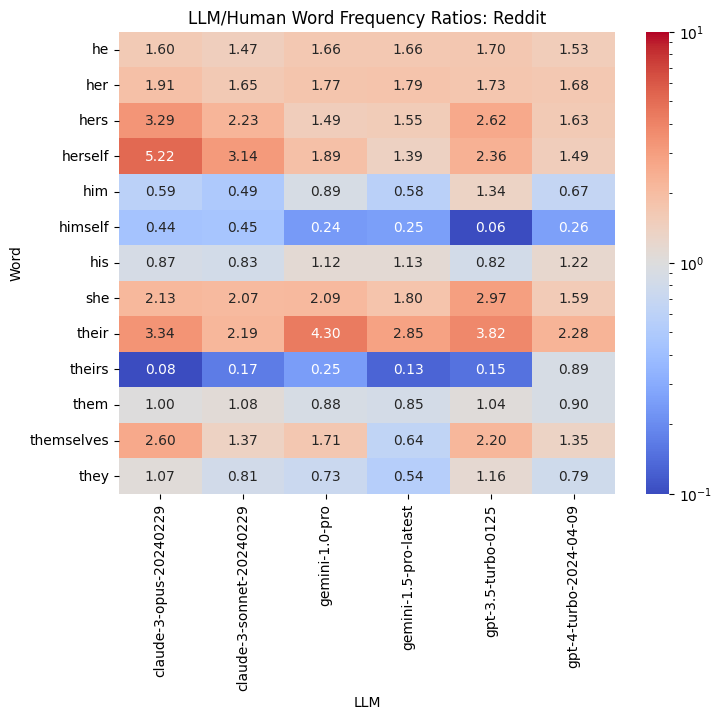

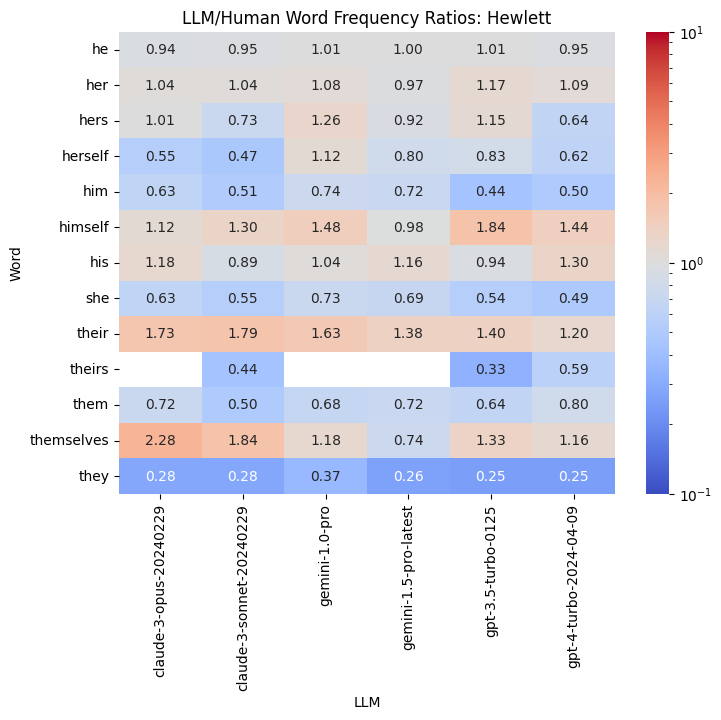

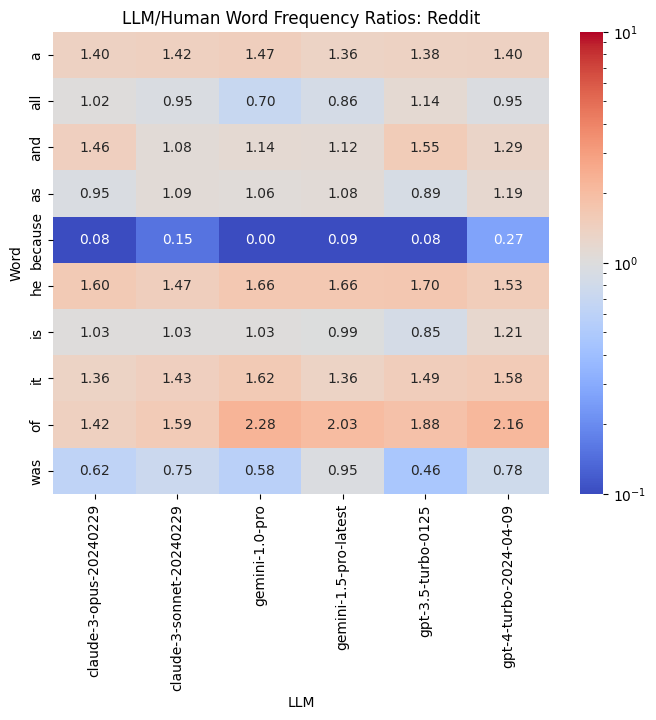

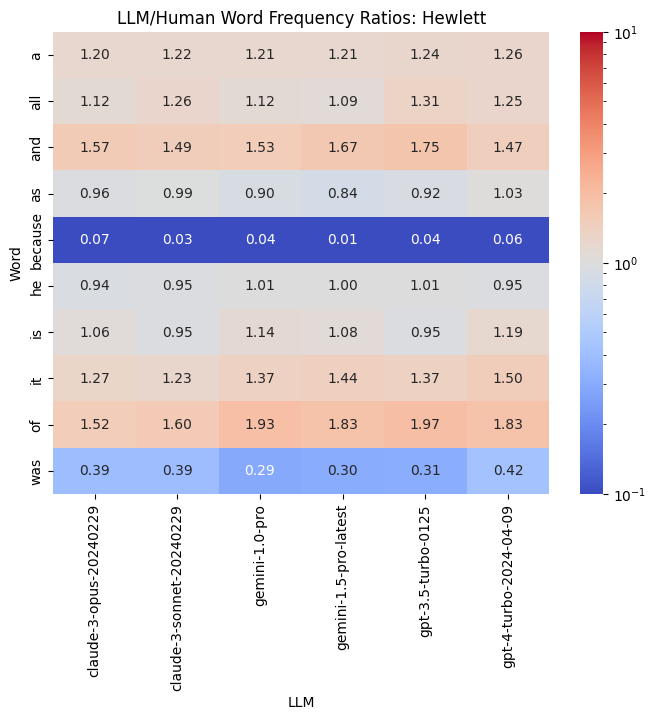

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator


pronouns = [
    "he",
    "him",
    "his",
    "himself",
    "she",
    "her",
    "hers",
    "herself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
]

high_coef_words = n_most_important.index.tolist()

for words in [pronouns, high_coef_words]:
    # Read the data and compute ratios for each dataset
    for dataset in DATASETS:
        ratios = []
        for word in words:
            df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
            human_word_counts = df_human["text"].str.count(word)
            human_word_freq = human_word_counts / df_human["text"].apply(
                lambda x: len(x.split())
            )
            human_word_avg_freq = human_word_freq.mean()

            for llm in LLMS:
                df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
                llm_word_counts = df_llm["text"].str.count(word)
                llm_word_freq = llm_word_counts / df_llm["text"].apply(
                    lambda x: len(x.split())
                )
                llm_word_avg_freq = llm_word_freq.mean()

                ratio = (
                    llm_word_avg_freq / human_word_avg_freq
                    if human_word_avg_freq
                    else np.nan
                )
                ratios.append({"word": word, "llm": llm, "ratio": ratio})

        ratios_df = pd.DataFrame(ratios)
        pivot_df = ratios_df.pivot(index="word", columns="llm", values="ratio")
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            pivot_df,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            norm=LogNorm(vmin=1 / 10, vmax=10),
        )
        plt.title(f"LLM/Human Word Frequency Ratios: {dataset.capitalize()}")
        plt.xlabel("LLM")
        plt.ylabel("Word")
        plt.show()

### AVOVA

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

pronouns = [
    "he",
    "him",
    "his",
    "himself",
    "she",
    "her",
    "hers",
    "herself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
]

high_coef_words = n_most_important.index.tolist()


def perform_anova(data, word):
    model = ols(f"Frequency ~ C(Source)", data=data.loc[data["Word"] == word]).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table


all_results = []
for dataset in DATASETS:
    for llm in LLMS:
        results = []
        for word in pronouns + high_coef_words:
            df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
            df_human["Source"] = "Human"
            df_human["Word"] = word
            df_human["Frequency"] = df_human["text"].str.count(word) / df_human[
                "text"
            ].apply(lambda x: len(x.split()))

            df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
            df_llm["Source"] = llm
            df_llm["Word"] = word
            df_llm["Frequency"] = df_llm["text"].str.count(word) / df_llm["text"].apply(
                lambda x: len(x.split())
            )

            all_data = pd.concat(
                [
                    df_human[["Source", "Word", "Frequency"]],
                    df_llm[["Source", "Word", "Frequency"]],
                ],
                ignore_index=True,
            )

            anova_result = perform_anova(all_data, word)
            f_value = anova_result["F"].values[0]
            p_value = anova_result["PR(>F)"].values[0]
            results.append({"word": word, "f_value": f_value, "p_value": p_value})

        results_df = pd.DataFrame(results)
        results_df["llm"] = llm
        results_df["dataset"] = dataset
        all_results.append(results_df)

all_results = pd.concat(all_results, ignore_index=True)
all_results

word      f_value        p_value                       llm  dataset
0            he   895.694214  1.264943e-156            gemini-1.0-pro   reddit
1           him     2.001190   1.573705e-01            gemini-1.0-pro   reddit
2           his     5.301345   2.143695e-02            gemini-1.0-pro   reddit
3       himself    35.651474   2.901924e-09            gemini-1.0-pro   reddit
4           she   108.924022   1.029057e-24            gemini-1.0-pro   reddit
5           her   166.922483   2.156199e-36            gemini-1.0-pro   reddit
6          hers    11.199304   8.372636e-04            gemini-1.0-pro   reddit
7       herself     8.878125   2.929628e-03            gemini-1.0-pro   reddit
8          they    15.051119   1.088875e-04            gemini-1.0-pro   reddit
9          them     2.178115   1.401828e-01            gemini-1.0-pro   reddit
10        their   243.588010   3.211011e-51            gemini-1.0-pro   reddit
11       theirs     3.373988   6.641887e-02            gemini-1.0-pro   reddit
12   themselves     9.909902   1.674293e-03            gemini-1.0-pro   reddit
13          was   157.658642   1.482369e-34            gemini-1.0-pro   reddit
14           it   516.730180   2.423100e-99            gemini-1.0-pro   reddit
15            a  2341.318105  2.134527e-315            gemini-1.0-pro   reddit
16           of  1369.266479  5.160137e-217            gemini-1.0-pro   reddit
17           as     7.821682   5.224154e-03            gemini-1.0-pro   reddit
18           is     0.967018   3.255739e-01            gemini-1.0-pro   reddit
19          and    36.765107   1.659650e-09            gemini-1.0-pro   reddit
20           he   895.694214  1.264943e-156            gemini-1.0-pro   reddit
21      because   138.895473   8.399012e-31            gemini-1.0-pro   reddit
22          all    86.190483   5.151365e-20            gemini-1.0-pro   reddit
23           he   983.366011  1.256706e-168     gemini-1.5-pro-latest   reddit
24          him    45.168798   2.507058e-11     gemini-1.5-pro-latest   reddit
25          his     7.795818   5.299087e-03     gemini-1.5-pro-latest   reddit
26      himself    38.754093   6.129778e-10     gemini-1.5-pro-latest   reddit
27          she    79.732975   1.149848e-18     gemini-1.5-pro-latest   reddit
28          her   208.249431   1.817877e-44     gemini-1.5-pro-latest   reddit
29         hers    12.881547   3.418551e-04     gemini-1.5-pro-latest   reddit
30      herself     1.742926   1.869576e-01     gemini-1.5-pro-latest   reddit
31         they    61.799926   6.936944e-15     gemini-1.5-pro-latest   reddit
32         them     4.865641   2.753850e-02     gemini-1.5-pro-latest   reddit
33        their   116.648221   2.704467e-26     gemini-1.5-pro-latest   reddit
34       theirs     6.227551   1.267794e-02     gemini-1.5-pro-latest   reddit
35   themselves     4.838293   2.797719e-02     gemini-1.5-pro-latest   reddit
36          was     1.477543   2.243389e-01     gemini-1.5-pro-latest   reddit
37           it   213.838533   1.522175e-45     gemini-1.5-pro-latest   reddit
38            a  1637.074038  5.105933e-247     gemini-1.5-pro-latest   reddit
39           of  1124.535255  4.033722e-187     gemini-1.5-pro-latest   reddit
40           as    13.258365   2.800182e-04     gemini-1.5-pro-latest   reddit
41           is     0.208030   6.483782e-01     gemini-1.5-pro-latest   reddit
42          and    26.362803   3.176133e-07     gemini-1.5-pro-latest   reddit
43           he   983.366011  1.256706e-168     gemini-1.5-pro-latest   reddit
44      because   107.812347   1.740013e-24     gemini-1.5-pro-latest   reddit
45          all    17.260158   3.431902e-05     gemini-1.5-pro-latest   reddit
46           he   457.621410   1.744375e-89  claude-3-sonnet-20240229   reddit
47          him    67.537279   4.224735e-16  claude-3-sonnet-20240229   reddit
48          his    13.955656   1.937521e-04  claude-3-sonnet-20240229   reddit
49      himself    16.273392   5.741603e-05  claude-3-sonnet-

## Mis-labels: GPT 3.5, human

In [21]:
df = pd.read_csv("results/binary_classification.csv")
df = df[df["llm"] == "gpt-3.5-turbo-0125"]
df = df.reset_index(drop=True)

random.seed(0)
np.random.seed(0)

mislabels = []
for _, dataset, _, _, df_test, _ in df.itertuples():
    df_test = pd.read_json(StringIO(df_test), orient="records")
    mislabeled = df_test[df_test["author"] != df_test["author_pred"]]
    # add all the mislabeled prompts to the results
    for _, row in mislabeled.iterrows():
        mislabels.append(
            {
                "prompt_id": row["prompt_id"],
                "text": row["text"],
                "author": row["author"],
                "author_pred": row["author_pred"],
                "dataset": dataset,
            }
        )
mislabels = pd.DataFrame(mislabels)

# Sample 1 prompt per dataset per prompt per author
sampled = (
    mislabels.groupby(["dataset", "prompt_id", "author", "author_pred"])
    .apply(lambda x: x.sample(1), include_groups=False)
    .reset_index(drop=True, level=4)
    .reset_index(drop=False)
)
sampled.to_csv("results/mislabeled.csv", index=False)
sampled

dataset  prompt_id              author         author_pred  \
0   hewlett          0  gpt-3.5-turbo-0125               human   
1   hewlett          1  gpt-3.5-turbo-0125               human   
2   hewlett          2               human  gpt-3.5-turbo-0125   
3   hewlett          3               human  gpt-3.5-turbo-0125   
4   hewlett          4               human  gpt-3.5-turbo-0125   
5   hewlett          5  gpt-3.5-turbo-0125               human   
6   hewlett          5               human  gpt-3.5-turbo-0125   
7   hewlett          6  gpt-3.5-turbo-0125               human   
8   hewlett          6               human  gpt-3.5-turbo-0125   
9   hewlett          7  gpt-3.5-turbo-0125               human   
10  hewlett          7               human  gpt-3.5-turbo-0125   
11   reddit          0  gpt-3.5-turbo-0125               human   
12   reddit          0               human  gpt-3.5-turbo-0125   
13   reddit          1               human  gpt-3.5-turbo-0125   
14   reddit          2  gpt-3.5-turbo-0125               human   
15   reddit          2               human  gpt-3.5-turbo-0125   
16   reddit          3  gpt-3.5-turbo-0125               human   
17   reddit          3               human  gpt-3.5-turbo-0125   
18   reddit          4  gpt-3.5-turbo-0125               human   
19   reddit          4               human  gpt-3.5-turbo-0125   
20   reddit          5  gpt-3.5-turbo-0125               human   
21   reddit          6  gpt-3.5-turbo-0125               human   
22   reddit          7  gpt-3.5-turbo-0125               human   
23   reddit          7               human  gpt-3.5-turbo-0125   

                                                 text  
0   [Your Name]\n[Your Address]\n[City, State, Zip...  
1   Censorship in libraries has been a topic of de...  
2   The cyclist in the essay, Do Not Exceed Posted...  
3   The author concludes with the paragraph, when...  
4   The mood created by the author in this memoir ...  
5   The builders of the Empire State Building face...  
6   The builders of the Empire State Building face...  
7   Title: The Art of Patience\n\nOnce upon a time...  
8   We had been patient enough on the plane ride t...  
9   I once witnessed firsthand how laughter played...  
10   Laughter is used as a "cure" for everything. ...  
11  In a distant corner of the galaxy, the peacefu...  
12  Since the first generation of stars the Stewar...  
13  FUCK I missed it all . O well . <newline> <new...  
14  Prologue:\n\nThe chill of the night wrapped ar...  
15  **The Tribe** <newline> <newline> They hunt in...  
16  In a quiet forest, a small deer looked around ...  
17  Potatoes have been one of the main staples for...  
18  The scent of fresh pine filled the air as Sara...  
19  As he took his final steps out of the enormous...  
20  Dear Mom,\n\nI hope this letter finds you well...  
21  In the bustling city of power-wielders where h...  
22  As they stood under the starlit sky, surrounde...  
23  The cold hard surfaces that lined the lab wall...

# Binary classification (6 LLMs together vs human)

We use a balanced dataset for this experiment. 

In [15]:
import random


N_TRIALS = 30

if not os.path.exists("results/binary_classification_llms_together.csv"):
    binary_classification = []
    for dataset in DATASETS:
        df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
        df_human["temp"] = HUMAN
        n_responses_per_prompt = df_human["prompt_id"].value_counts().min()

        # distribute the n_responses_per_prompt responses to each LLM as equally as possible
        n_responses_per_prompt_per_llm = {
            llm: n_responses_per_prompt // len(LLMS) for llm in LLMS
        }
        for llm in random.sample(LLMS, n_responses_per_prompt % len(LLMS)):
            n_responses_per_prompt_per_llm[llm] += 1

        llm_dfs = []
        for llm in LLMS:
            df = pd.read_csv(f"{dataset}/responses/{llm}.csv")
            df["author"] = "llm"

            df = (
                df.groupby("prompt_id")
                .apply(
                    lambda x: x.sample(n_responses_per_prompt_per_llm[llm]),
                    include_groups=False,
                )
                .reset_index()
            )
            llm_dfs.append(df)
        df_llm = pd.concat(llm_dfs, ignore_index=True)

        df = pd.concat([df_human, df_llm], ignore_index=True)

        for trial in tqdm(range(N_TRIALS), desc=f"Running {dataset} trials"):
            df_test = classify(df, fw_oseah)
            binary_classification.append(
                {
                    "dataset": dataset,
                    "trial": trial,
                    "df_test": df_test.to_json(orient="records"),
                }
            )
    df_multiclass_classification = pd.DataFrame(binary_classification)
    df_multiclass_classification.to_csv(
        "results/binary_classification_llms_together.csv", index=False
    )

Reddit dataset row entropies:
[0.20096167 0.49078222]


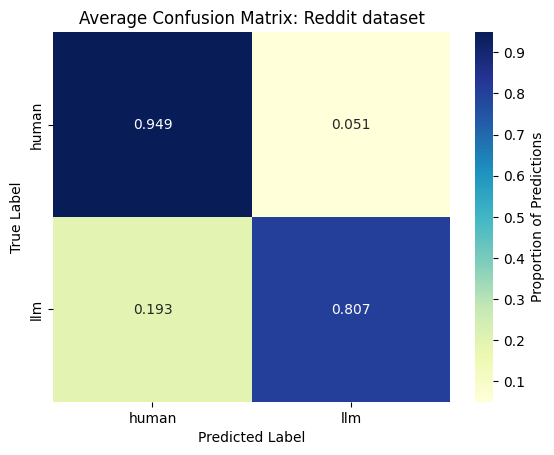

Hewlett dataset row entropies:
[0.30137948 0.34160896]


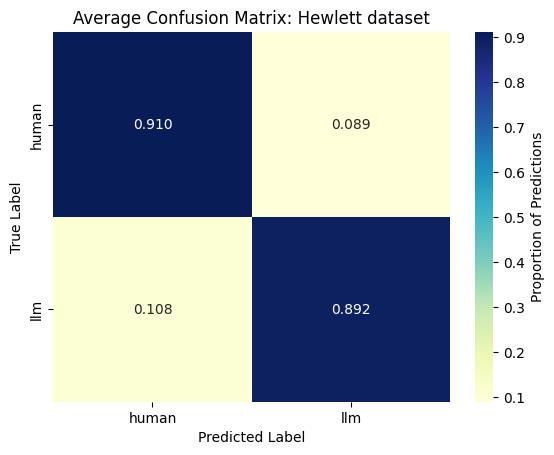

In [16]:
df_bin = pd.read_csv("results/binary_classification_llms_together.csv")

for dataset in DATASETS:
    df = df_bin[df_bin["dataset"] == dataset]
    cms = []
    for df_test in df["df_test"]:
        df_test = pd.read_json(StringIO(df_test), orient="records")
        cm = confusion_matrix(df_test["author"], df_test["author_pred"])
        cms.append(cm)
    avg_conf_matrix = np.mean(cms, axis=0)
    avg_conf_matrix = avg_conf_matrix / avg_conf_matrix.sum(axis=1, keepdims=True)

    row_entropies = -np.sum(avg_conf_matrix * np.log(avg_conf_matrix), axis=1)
    print(f"{dataset.capitalize()} dataset row entropies:")
    print(row_entropies)

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".3f",
        cbar_kws={"label": "Proportion of Predictions"},
        xticklabels=[HUMAN, "llm"],
        yticklabels=[HUMAN, "llm"],
    )
    plt.title(f"Average Confusion Matrix: {dataset.capitalize()} dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Multiclass classification (all 7 authors)

Takeaways:
- The model generally predicts the "premium" versions of each model family more accurately i.e. the larger models have a more distinctive style. This result is consistent with the next experiments involving just the LLMs.

In [17]:
N_TRIALS = 30

if not os.path.exists("results/multiclass_classification.csv"):
    multiclass_classification = []
    for dataset in DATASETS:
        dfs = []
        for author in AUTHORS:
            df = pd.read_csv(f"{dataset}/responses/{author}.csv")
            df["author"] = author
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)

        for trial in tqdm(range(N_TRIALS), desc=f"Running {dataset} trials"):
            df_test = classify(df, fw_oseah)
            multiclass_classification.append(
                {
                    "dataset": dataset,
                    "trial": trial,
                    "df_test": df_test.to_json(orient="records"),
                }
            )
    df_multiclass_classification = pd.DataFrame(multiclass_classification)
    df_multiclass_classification.to_csv(
        "results/multiclass_classification.csv", index=False
    )

Reddit dataset row entropies:
[1.64930367 1.66572041 1.32616578 1.14986117 1.56100573 1.18951228
 0.51339947]


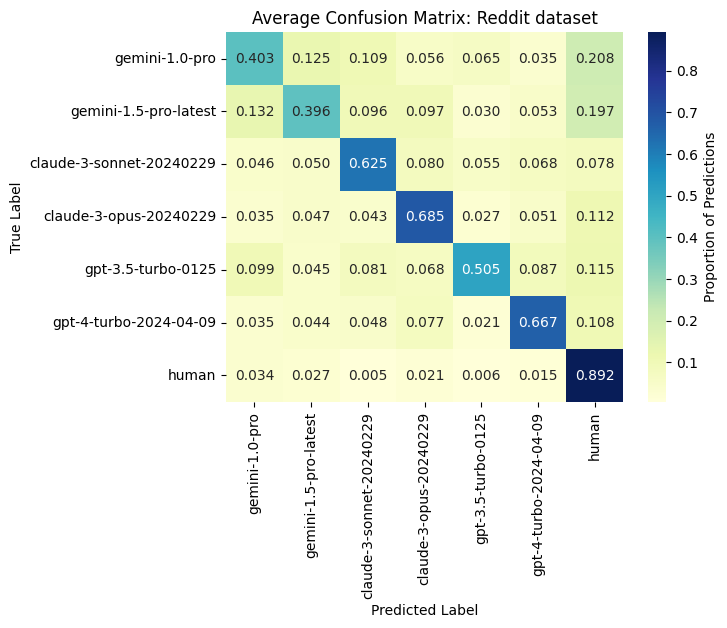

Hewlett dataset row entropies:
[1.88196486 1.81874195 1.82179295 1.4389291  1.38202884 0.95355031
 0.57334423]


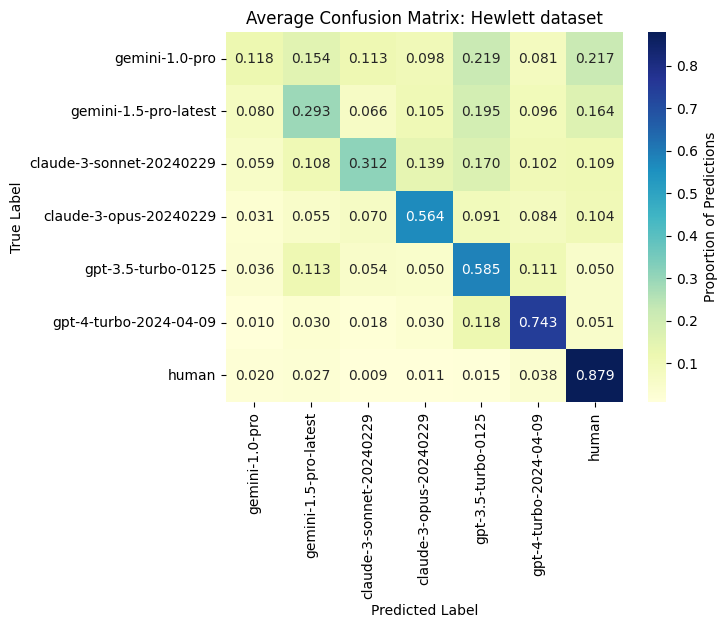

In [18]:
df_multi = pd.read_csv("results/multiclass_classification.csv")

for dataset in DATASETS:
    df_multi_cur = df_multi[df_multi["dataset"] == dataset]
    cms = []
    for df_test in df_multi_cur["df_test"]:
        df_test = pd.read_json(StringIO(df_test), orient="records")
        cm = confusion_matrix(df_test["author"], df_test["author_pred"])
        cms.append(cm)
    avg_conf_matrix = np.mean(cms, axis=0)
    avg_conf_matrix = avg_conf_matrix / avg_conf_matrix.sum(axis=1, keepdims=True)

    row_entropies = -np.sum(avg_conf_matrix * np.log(avg_conf_matrix), axis=1)
    print(f"{dataset.capitalize()} dataset row entropies:")
    print(row_entropies)

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".3f",
        cbar_kws={"label": "Proportion of Predictions"},
        xticklabels=AUTHORS,
        yticklabels=AUTHORS,
    )
    plt.title(f"Average Confusion Matrix: {dataset.capitalize()} dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Multiclass classification (only the 6 LLMs)

Takeaways:
- Again, the model (generally) predicts the "premium" versions of each model family better; the larger models have a more distinctive style.

In [19]:
N_TRIALS = 30

if not os.path.exists("results/multiclass_classification_llms.csv"):
    multiclass_classification = []
    for dataset in DATASETS:
        dfs = []
        for llm in LLMS:
            df = pd.read_csv(f"{dataset}/responses/{llm}.csv")
            df["author"] = llm
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)

        for trial in tqdm(range(N_TRIALS), desc=f"Running {dataset} trials"):
            df_test = classify(df, fw_oseah)
            multiclass_classification.append(
                {
                    "dataset": dataset,
                    "trial": trial,
                    "df_test": df_test.to_json(orient="records"),
                }
            )
    df_multiclass_classification = pd.DataFrame(multiclass_classification)
    df_multiclass_classification.to_csv(
        "results/multiclass_classification_llms.csv", index=False
    )

Reddit dataset row entropies:
[1.43428    1.44807578 1.23037892 0.93854895 1.45589883 1.03816617]


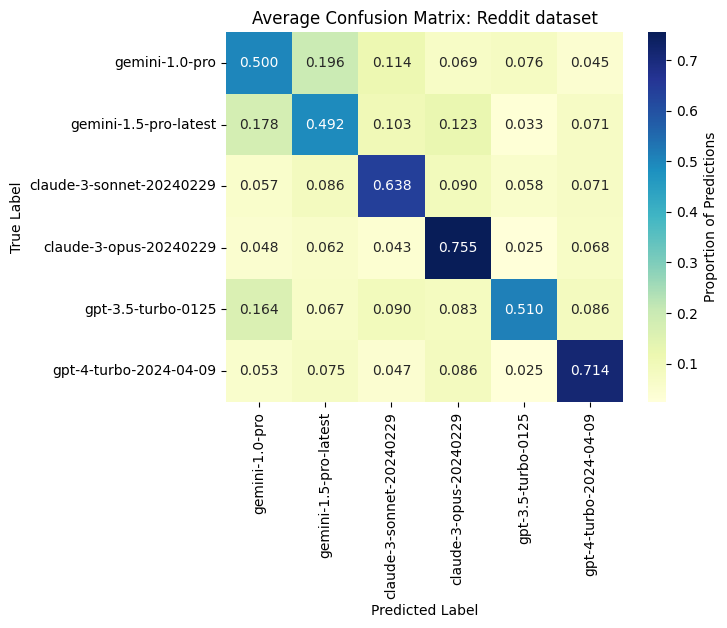

Hewlett dataset row entropies:
[1.76552446 1.62743815 1.71529321 1.27289608 1.32657187 0.72812566]


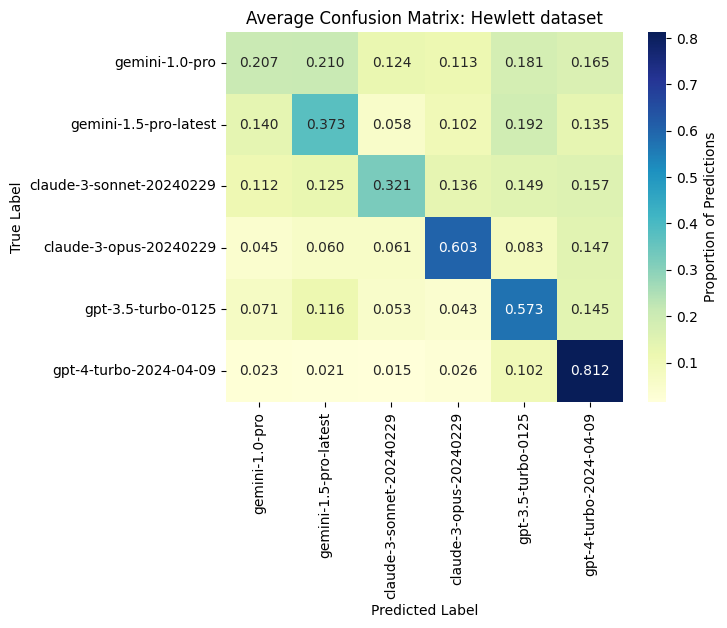

In [20]:
df_multi = pd.read_csv("results/multiclass_classification_llms.csv")

for dataset in DATASETS:
    df_multi_cur = df_multi[df_multi["dataset"] == dataset]
    cms = []
    for df_test in df_multi_cur["df_test"]:
        df_test = pd.read_json(StringIO(df_test), orient="records")
        cm = confusion_matrix(df_test["author"], df_test["author_pred"])
        cms.append(cm)
    avg_conf_matrix = np.mean(cms, axis=0)
    avg_conf_matrix = avg_conf_matrix / avg_conf_matrix.sum(axis=1, keepdims=True)

    row_entropies = -np.sum(avg_conf_matrix * np.log(avg_conf_matrix), axis=1)
    print(f"{dataset.capitalize()} dataset row entropies:")
    print(row_entropies)

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".3f",
        cbar_kws={"label": "Proportion of Predictions"},
        xticklabels=LLMS,
        yticklabels=LLMS,
    )
    plt.title(f"Average Confusion Matrix: {dataset.capitalize()} dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Temperature experiments

In [21]:
import random

N_TRIALS = 30
fw = fw_oseah
TEMPS = [f"{0.1 * i:.1f}" for i in range(16)]


if not os.path.exists("results/binary_classification_temp.csv"):
    binary_classification = []
    for dataset in DATASETS:
        df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
        df_human["author"] = HUMAN
        for temp in TEMPS:
            df_temp = pd.read_csv(f"{dataset}/responses/{GPT_35}_{temp}.csv")
            df_temp["author"] = temp
            df = pd.concat([df_human, df_temp], ignore_index=True)
            for trial in tqdm(range(N_TRIALS), desc=f"{dataset} {temp}"):
                df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

                binary_classification.append(
                    {
                        "dataset": dataset,
                        "temp": temp,
                        "trial": trial,
                        "df_test": df_test.to_json(orient="records"),
                        "df_coefs": df_coefs.to_json(orient="records"),
                    }
                )

    df_binary_classification = pd.DataFrame(binary_classification)
    df_binary_classification.to_csv(
        f"results/binary_classification_temp.csv", index=False
    )

mean accacies:
   dataset  temp  accuracy
0   reddit   0.0  0.889333
1   reddit   0.1  0.904583
2   reddit   0.2  0.924417
3   reddit   0.3  0.885667
4   reddit   0.4  0.895833
5   reddit   0.5  0.894583
6   reddit   0.6  0.928167
7   reddit   0.7  0.904750
8   reddit   0.8  0.893167
9   reddit   0.9  0.885833
10  reddit   1.0  0.910000
11  reddit   1.1  0.911417
12  reddit   1.2  0.914250
13  reddit   1.3  0.901000
14  reddit   1.4  0.871333
15  reddit   1.5  0.885333


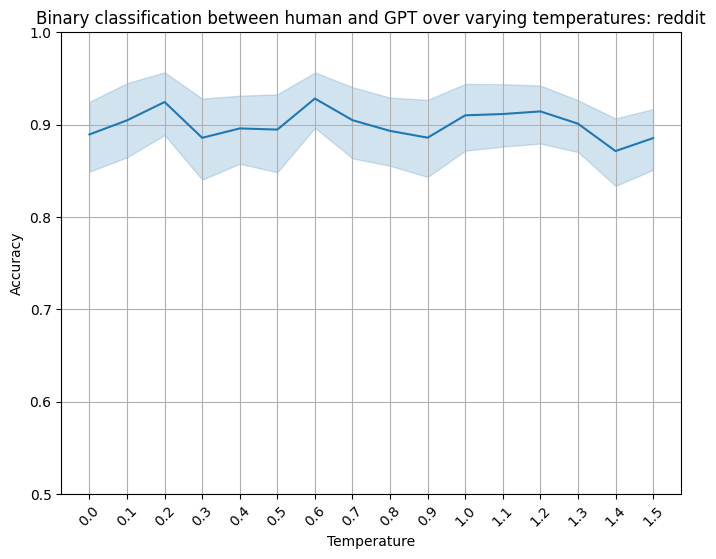

mean accacies:
    dataset  temp  accuracy
0   hewlett   0.0  0.949000
1   hewlett   0.1  0.940667
2   hewlett   0.2  0.948917
3   hewlett   0.3  0.949250
4   hewlett   0.4  0.943250
5   hewlett   0.5  0.942500
6   hewlett   0.6  0.936833
7   hewlett   0.7  0.944083
8   hewlett   0.8  0.944833
9   hewlett   0.9  0.950417
10  hewlett   1.0  0.941583
11  hewlett   1.1  0.937167
12  hewlett   1.2  0.949250
13  hewlett   1.3  0.946083
14  hewlett   1.4  0.945417
15  hewlett   1.5  0.953750


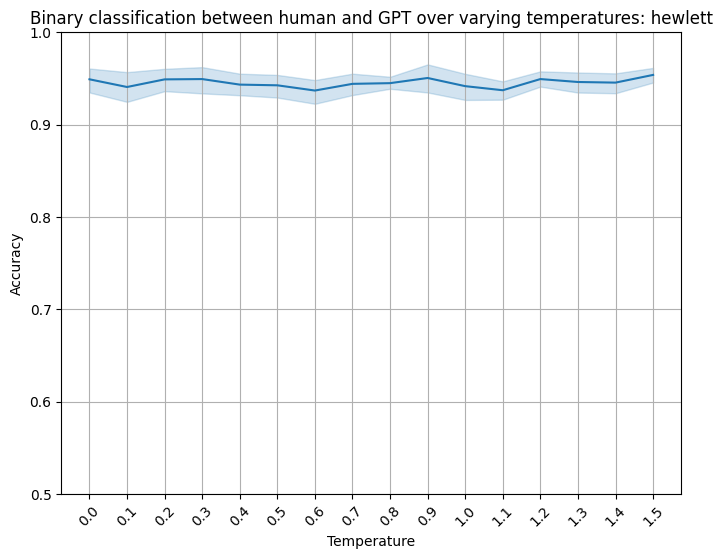

In [22]:
from io import StringIO


df_temp = pd.read_csv("results/binary_classification_temp.csv")
for dataset in DATASETS:
    df_temp_dataset = df_temp[df_temp["dataset"] == dataset]
    df_acc = []
    for _, dataset, temp, _, df_test, _ in df_temp_dataset.itertuples():
        df_test = pd.read_json(StringIO(df_test), orient="records")
        acc = (df_test["author"] == df_test["author_pred"]).mean()
        df_acc.append({"dataset": dataset, "temp": temp, "accuracy": acc})
    df_acc = pd.DataFrame(df_acc)
    print(f"mean accacies:\n{df_acc.groupby(['dataset', 'temp']).mean().reset_index()}")

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_acc, x="temp", y="accuracy")
    plt.title(
        f"Binary classification between human and GPT over varying temperatures: {dataset}"
    )
    plt.ylabel("Accuracy")
    plt.xlabel("Temperature")
    plt.ylim(0.5, 1)
    plt.grid()
    plt.xticks(rotation=45, ticks=[float(temp) for temp in TEMPS], labels=TEMPS)
    plt.show()

# Dimensionality reduction: PCA and t-SNE

## All prompts over LLMs + human

PCA explained variance ratio: [0.06028337 0.02478843]


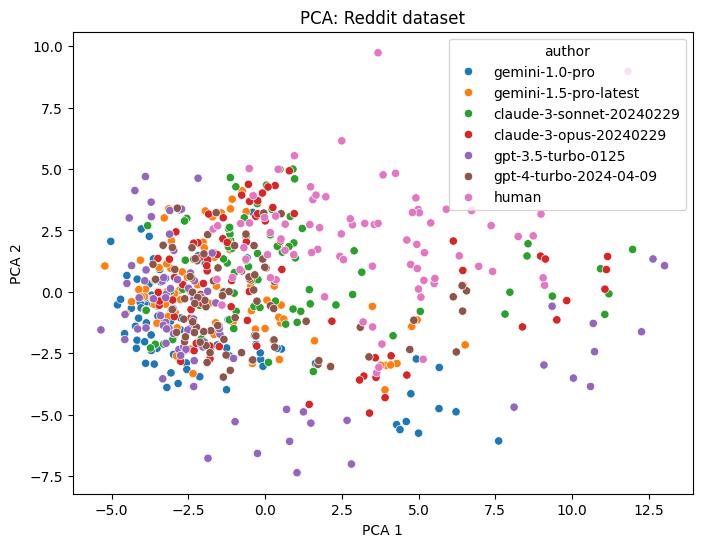

PCA explained variance ratio: [0.04828434 0.03793776]


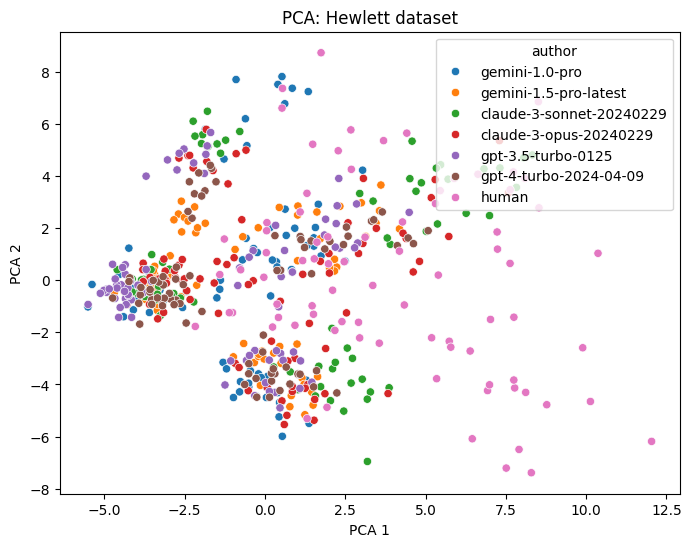

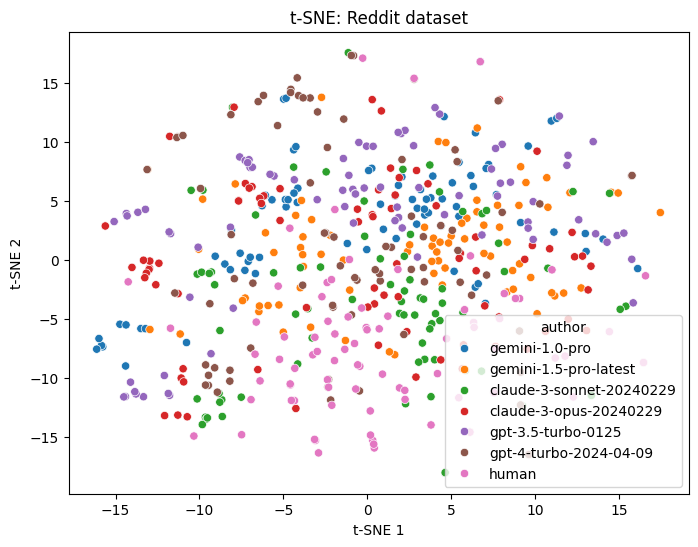

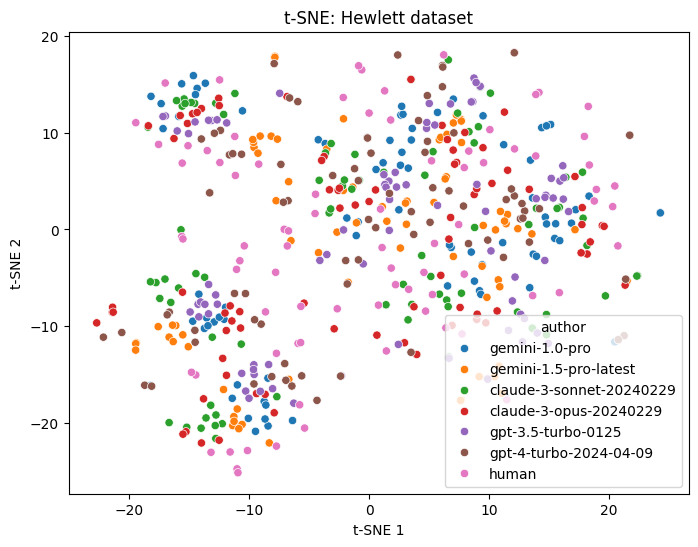

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for reducer, reducer_name in [(PCA, "PCA"), (TSNE, "t-SNE")]:
    for dataset in DATASETS:
        df = []
        for author in AUTHORS:
            df_author = pd.read_csv(f"{dataset}/responses/{author}.csv")

            # sample 10 responses per author per prompt
            df_author = (
                df_author.groupby("prompt_id")
                .apply(lambda x: x.sample(10), include_groups=False)
                .reset_index(drop=True)
            )
            df_author["author"] = author
            df.append(df_author)
        df = pd.concat(df, ignore_index=True)

        z_scores_transformer = ZScoreTransformer(fw_oseah)
        z_scores = z_scores_transformer.fit_transform(df["text"])

        dim_reducer = reducer(n_components=2)
        z_scores_reduced = dim_reducer.fit_transform(z_scores)

        if reducer_name == "PCA":
            print(
                f"{reducer_name} explained variance ratio: {dim_reducer.explained_variance_ratio_}"
            )

        df_reduced = pd.DataFrame(
            z_scores_reduced, columns=[f"{reducer_name} 1", f"{reducer_name} 2"]
        )
        df_reduced["author"] = df["author"]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=df_reduced, x=f"{reducer_name} 1", y=f"{reducer_name} 2", hue="author"
        )
        plt.title(f"{reducer_name}: {dataset.capitalize()} dataset")
        plt.show()

## By prompt over LLMs + human

PCA explained variance ratio: [0.06934964 0.02414664]


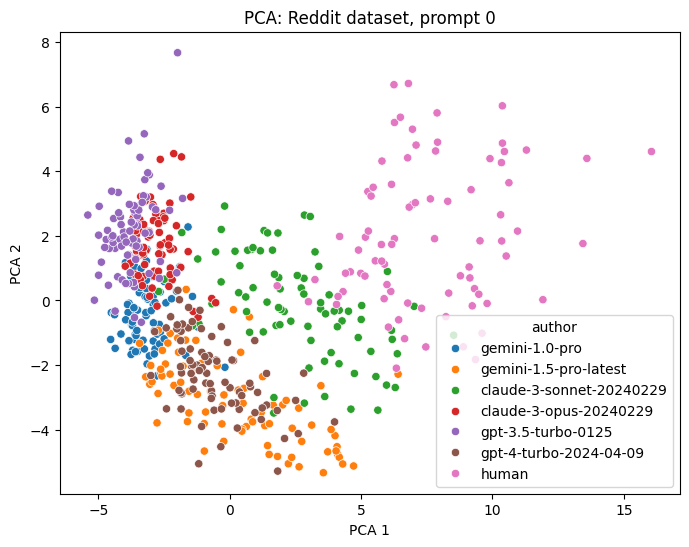

PCA explained variance ratio: [0.05684874 0.02111301]


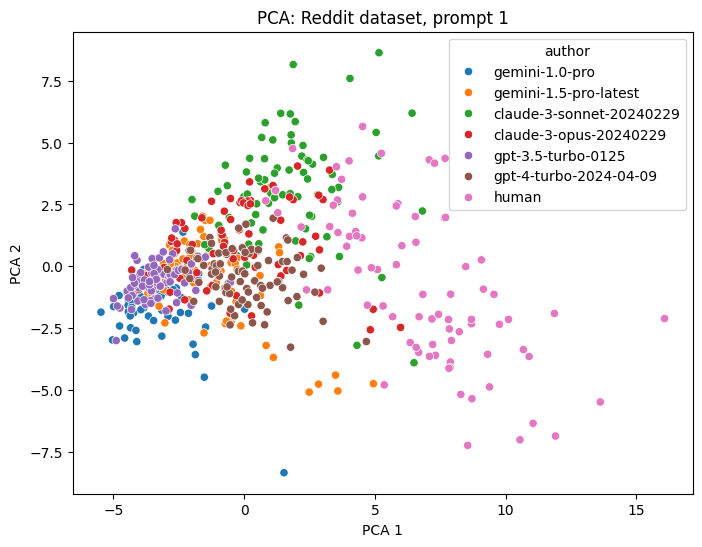

PCA explained variance ratio: [0.05252286 0.02483032]


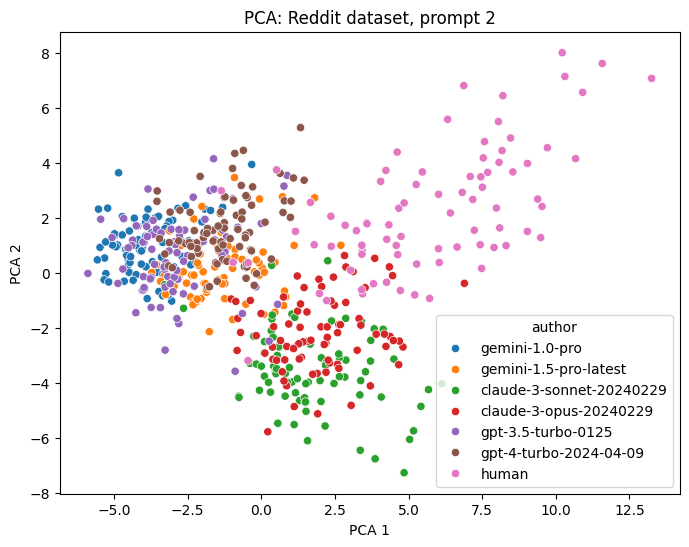

PCA explained variance ratio: [0.05820319 0.02045662]


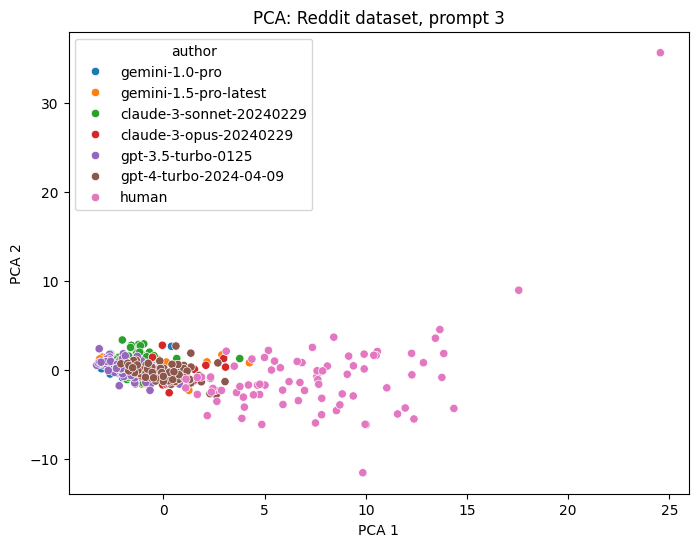

PCA explained variance ratio: [0.04378975 0.02564342]


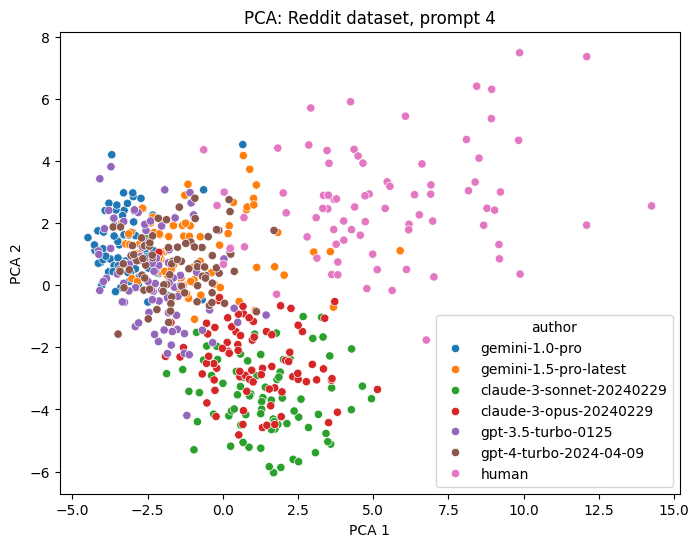

PCA explained variance ratio: [0.05288456 0.03146399]


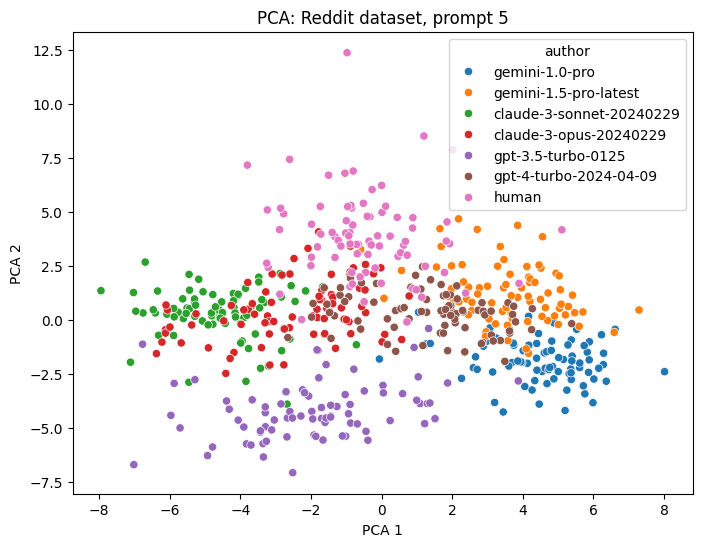

PCA explained variance ratio: [0.05452709 0.03465623]


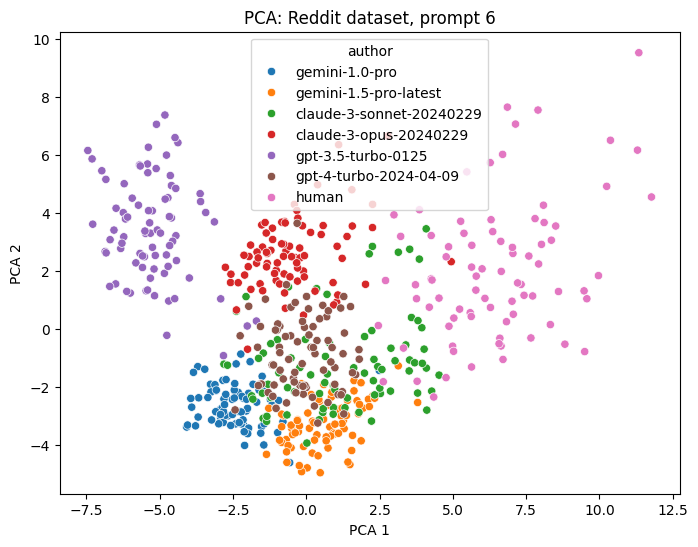

PCA explained variance ratio: [0.03486099 0.02120361]


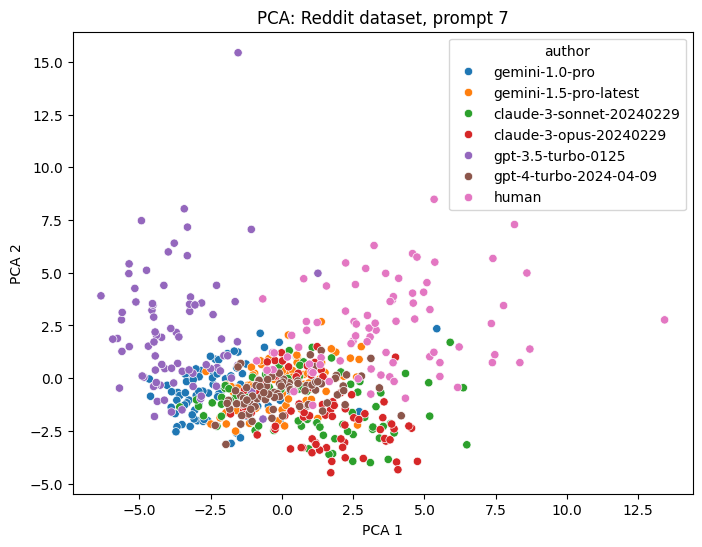

PCA explained variance ratio: [0.07125089 0.02572037]


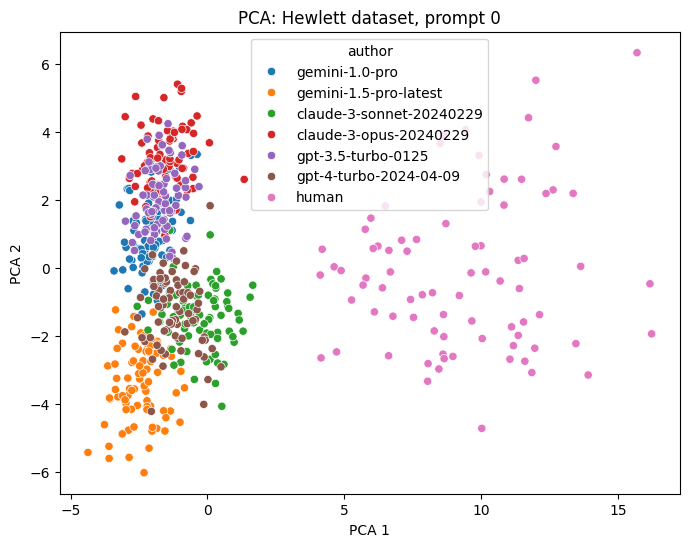

PCA explained variance ratio: [0.06920797 0.02448958]


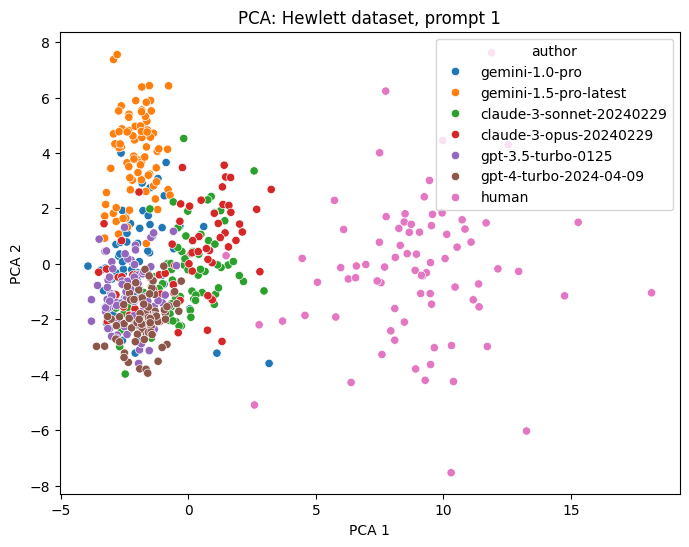

PCA explained variance ratio: [0.0520008 0.0255165]


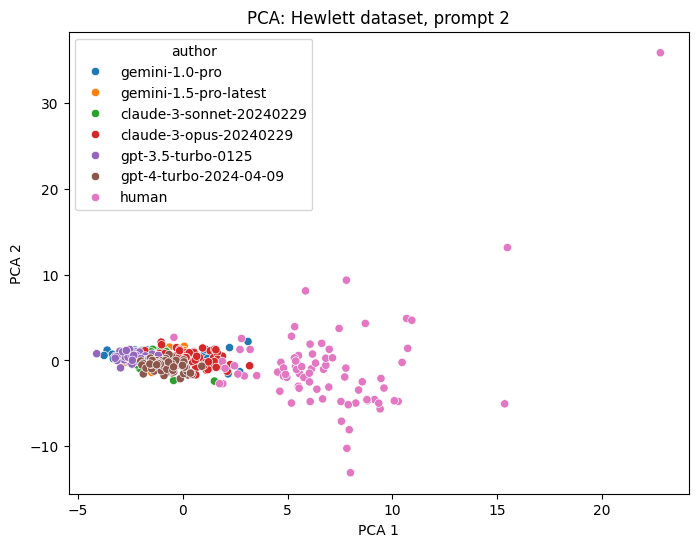

PCA explained variance ratio: [0.05708129 0.02351521]


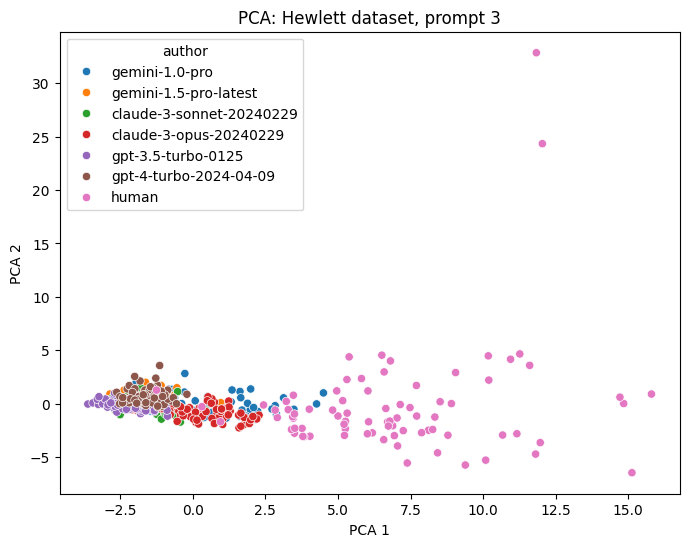

PCA explained variance ratio: [0.05327192 0.02342987]


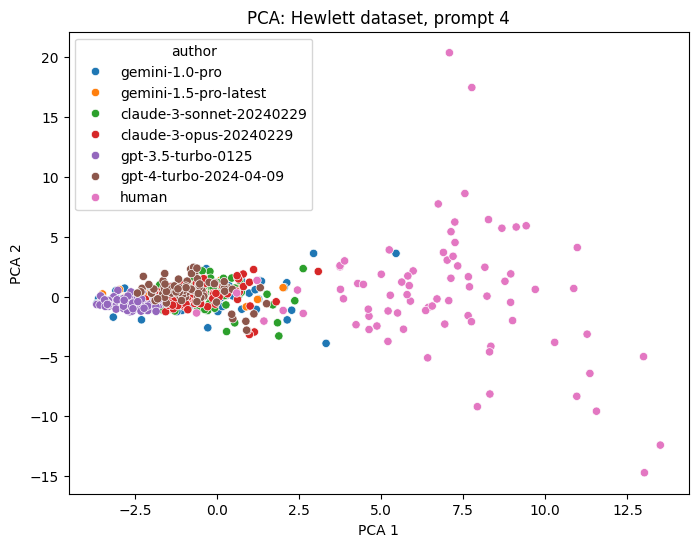

PCA explained variance ratio: [0.05173768 0.03508415]


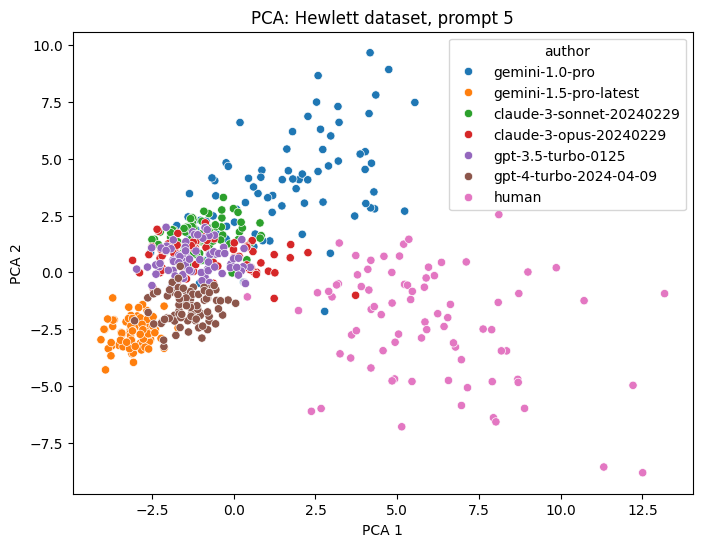

PCA explained variance ratio: [0.04409975 0.02732113]


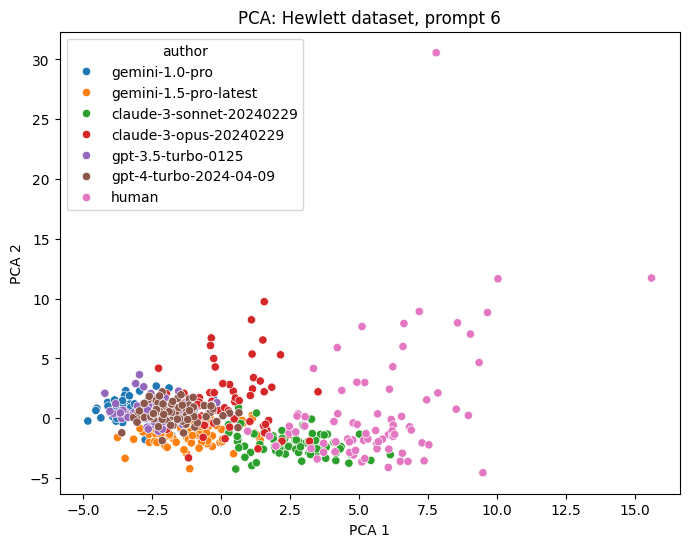

PCA explained variance ratio: [0.04673957 0.02815775]


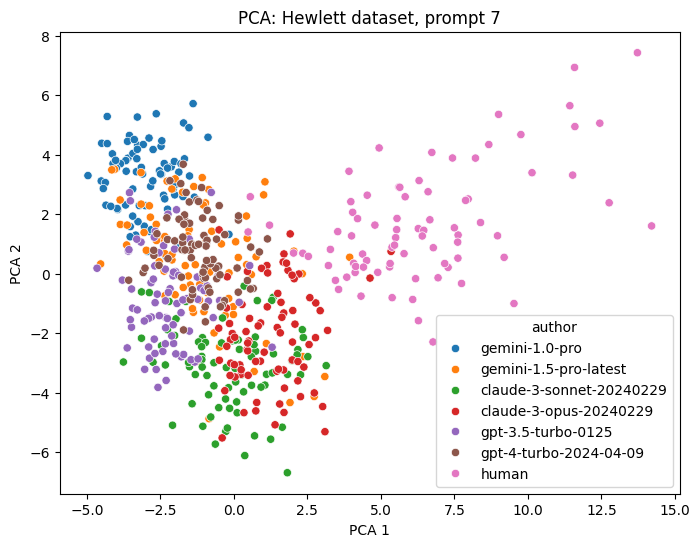

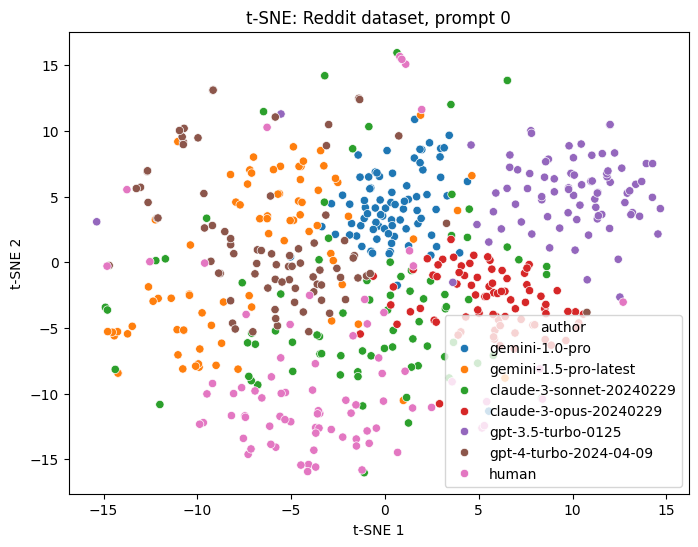

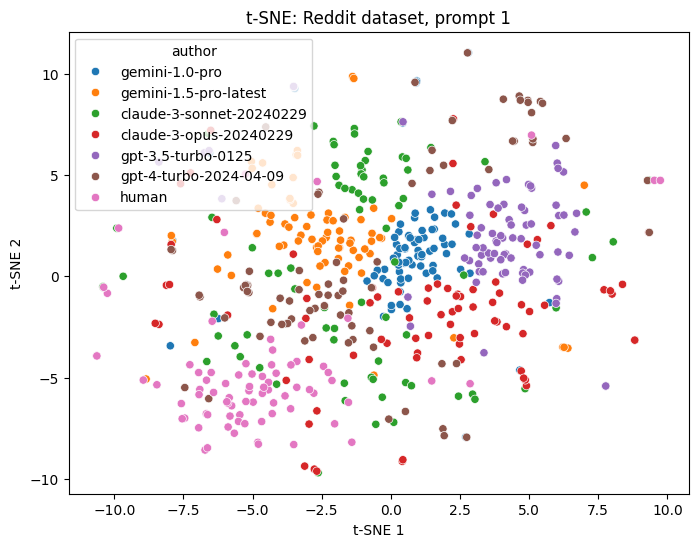

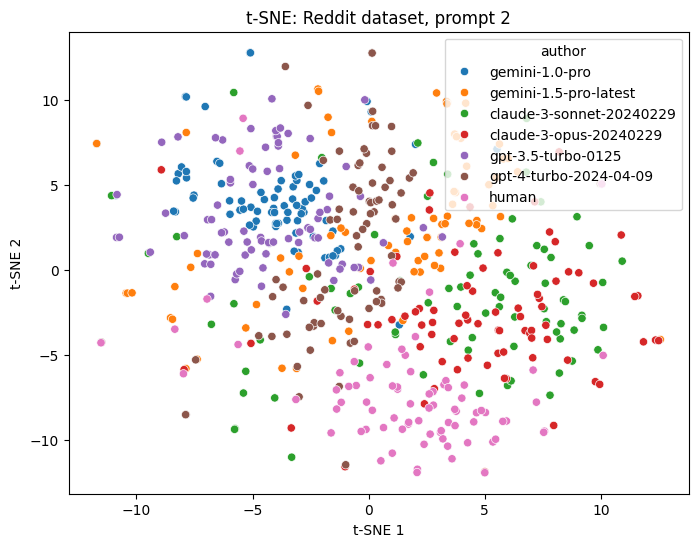

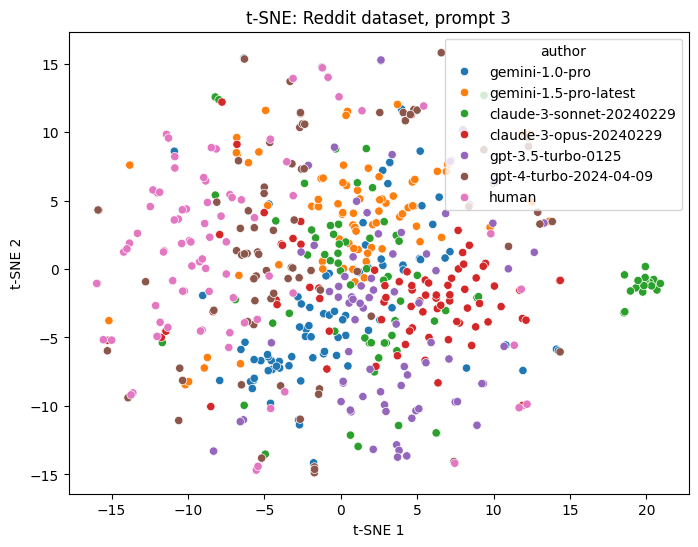

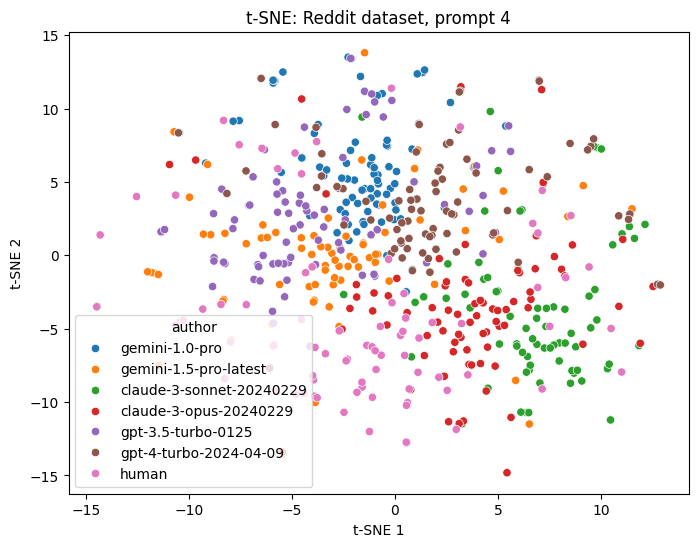

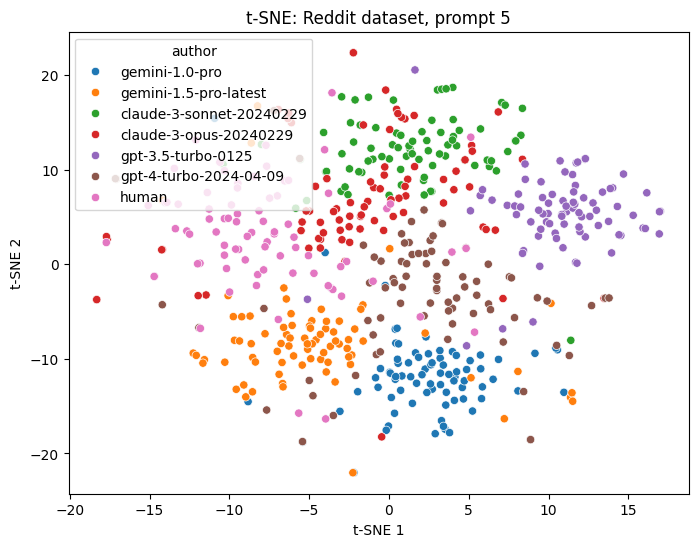

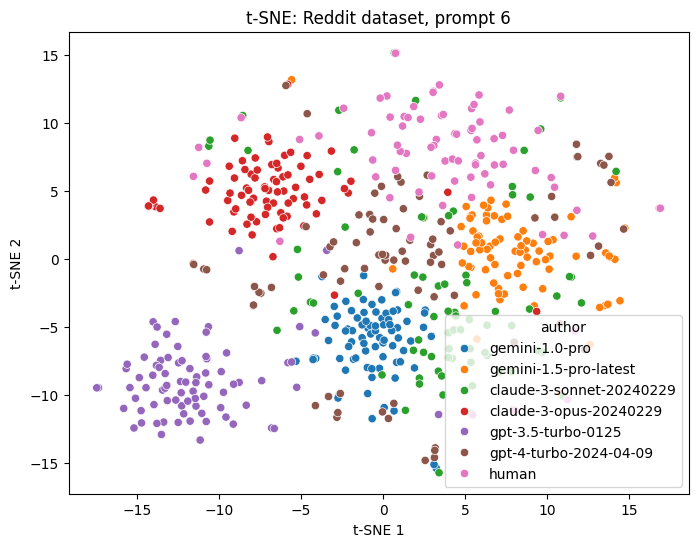

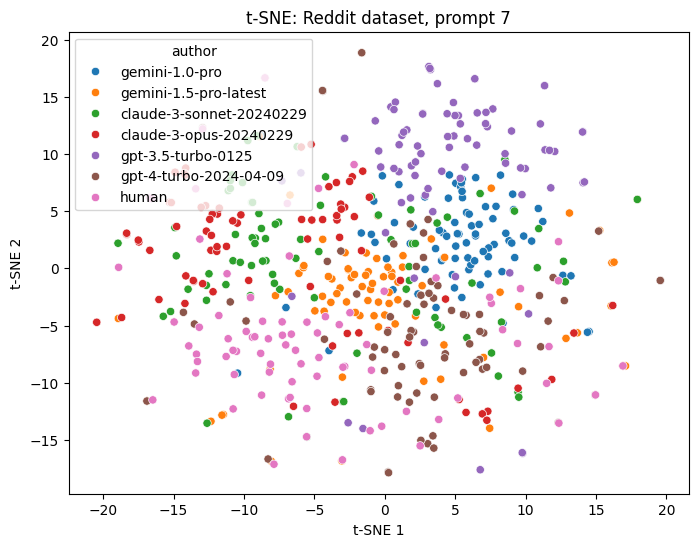

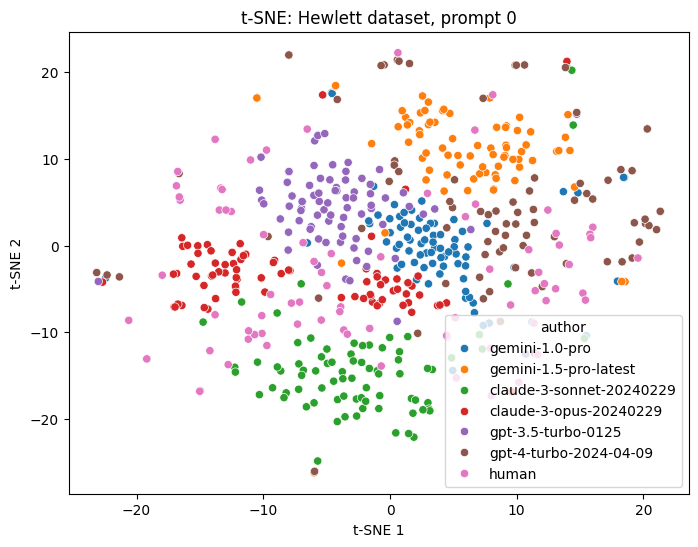

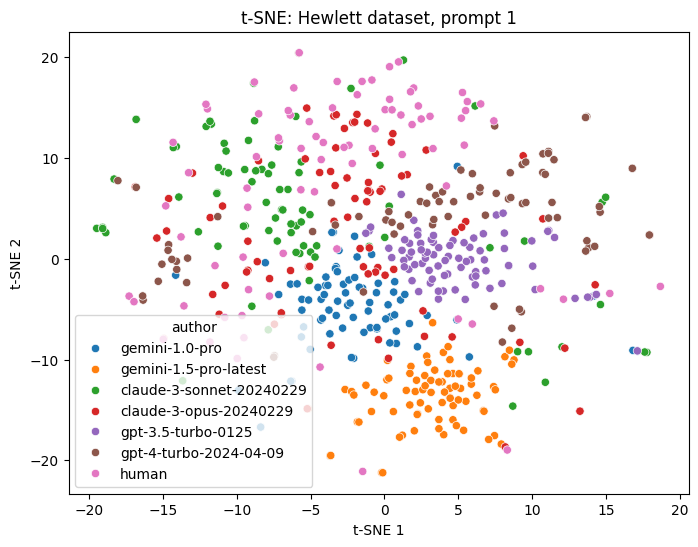

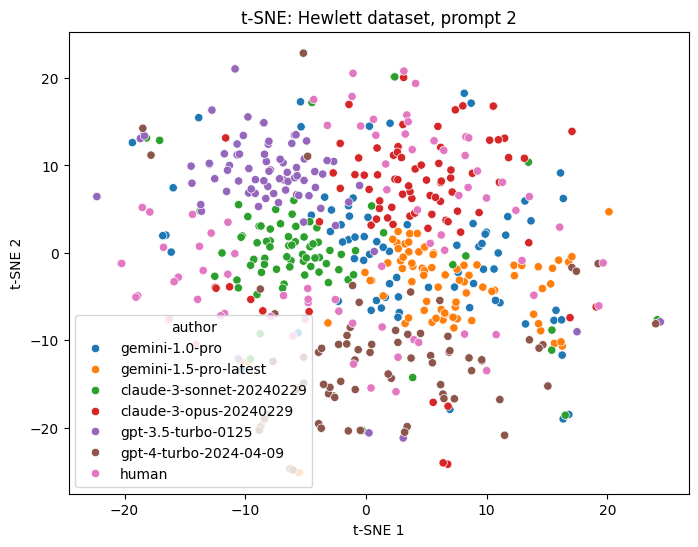

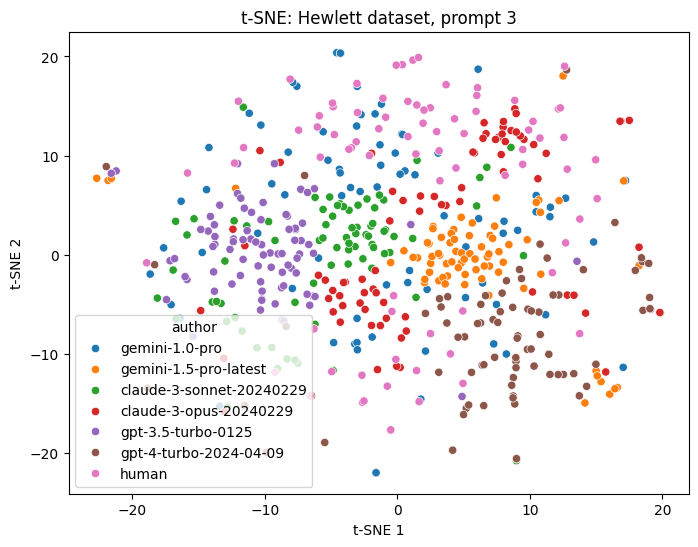

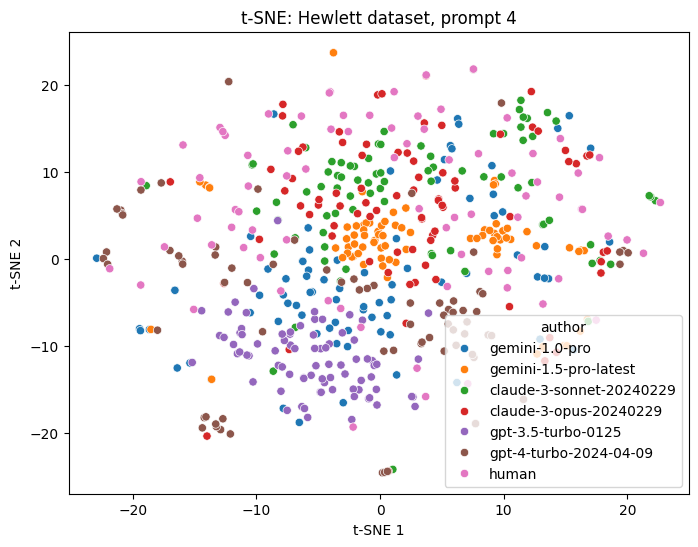

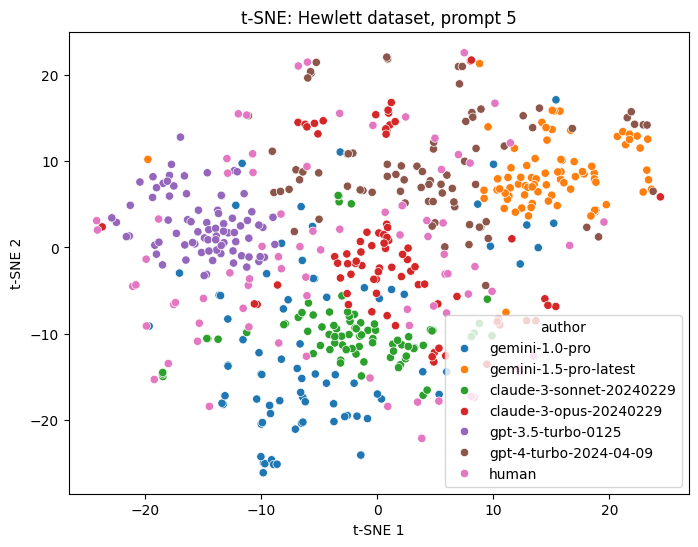

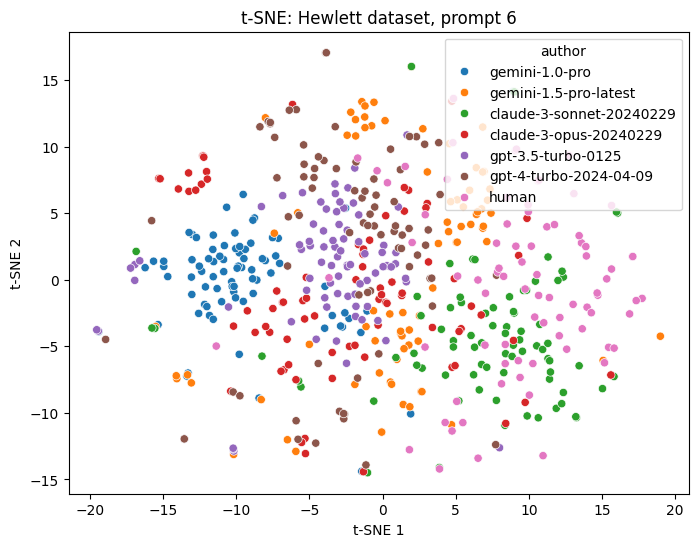

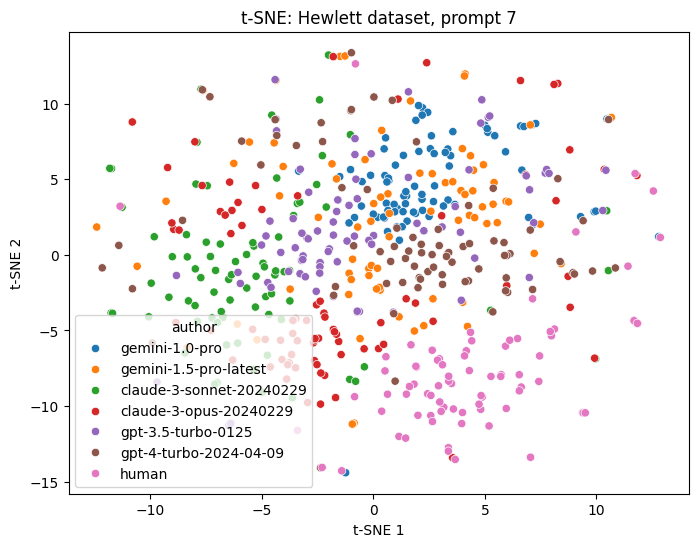

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


for reducer, reducer_name in [(PCA, "PCA"), (TSNE, "t-SNE")]:
    for dataset in DATASETS:
        df = []
        for author in AUTHORS:
            df_author = pd.read_csv(f"{dataset}/responses/{author}.csv")
            df_author["author"] = author

            # sample 80 responses per author per prompt
            df_author = (
                df_author.groupby("prompt_id")
                .apply(lambda x: x.sample(80, random_state=1), include_groups=False)
                .reset_index(drop=True, level=1)
                .reset_index(drop=False)
            )
            df.append(df_author)

        df = pd.concat(df, ignore_index=True)

        for prompt_id in df["prompt_id"].unique():
            df_cur = df[df["prompt_id"] == prompt_id].reset_index(drop=True)

            z_scores_transformer = ZScoreTransformer(fw_oseah)
            z_scores = z_scores_transformer.fit_transform(df_cur["text"])

            dim_reducer = reducer(n_components=2)
            z_scores_reduced = dim_reducer.fit_transform(z_scores)

            if reducer_name == "PCA":
                print(
                    f"{reducer_name} explained variance ratio: {dim_reducer.explained_variance_ratio_}"
                )

            df_reduced = pd.DataFrame(
                z_scores_reduced, columns=[f"{reducer_name} 1", f"{reducer_name} 2"]
            )
            df_reduced["author"] = df_cur["author"]

            plt.figure(figsize=(8, 6))
            sns.scatterplot(
                data=df_reduced,
                x=f"{reducer_name} 1",
                y=f"{reducer_name} 2",
                hue="author",
                palette="tab10",
            )
            plt.title(
                f"{reducer_name}: {dataset.capitalize()} dataset, prompt {prompt_id}"
            )
            plt.show()

## All prompts over GPT 3.5 temperatures

PCA explained variance ratio: [0.06508431 0.02950213]


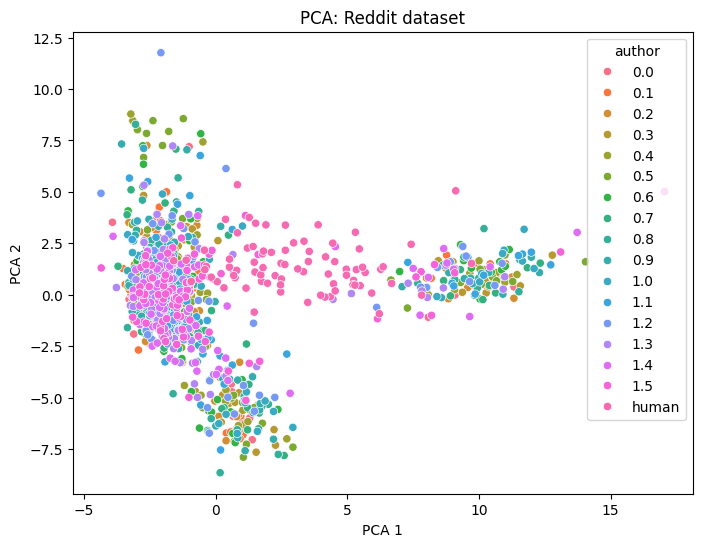

PCA explained variance ratio: [0.05715094 0.04551058]


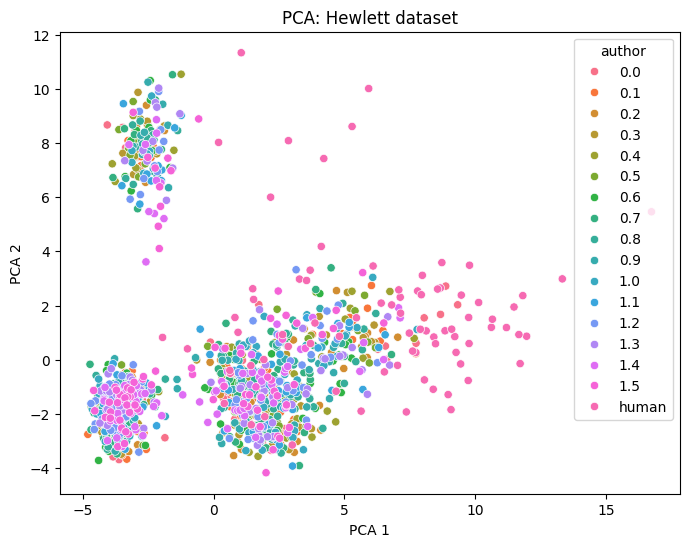

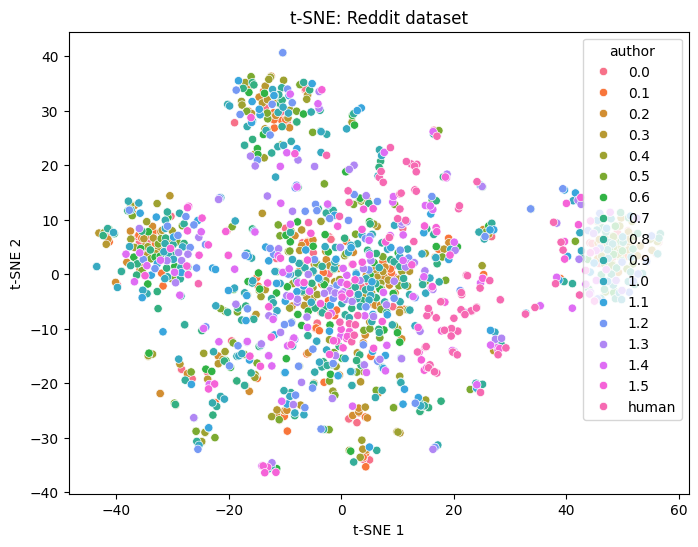

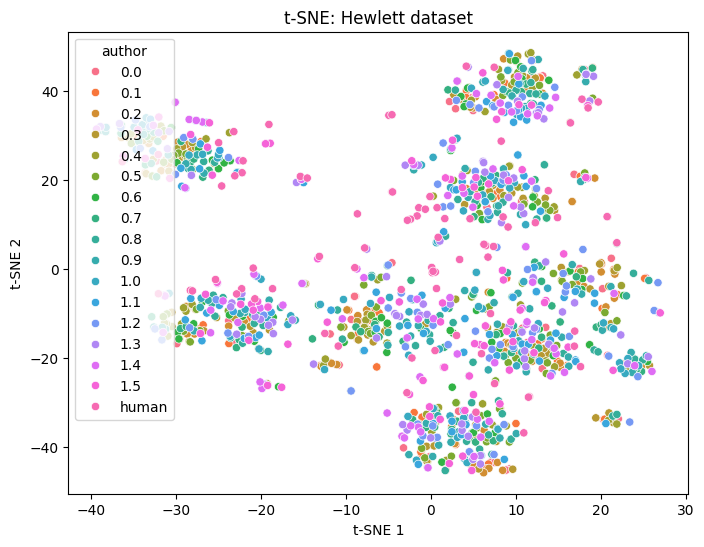

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for reducer, reducer_name in [(PCA, "PCA"), (TSNE, "t-SNE")]:
    for dataset in DATASETS:
        df = []
        for author in TEMPS + [HUMAN]:
            df_author = (
                pd.read_csv(f"{dataset}/responses/{author}.csv")
                if author == HUMAN
                else pd.read_csv(f"{dataset}/responses/{GPT_35}_{author}.csv")
            )

            # sample 10 responses per author per prompt
            df_author = (
                df_author.groupby("prompt_id")
                .apply(lambda x: x.sample(10), include_groups=False)
                .reset_index(drop=True)
            )
            df_author["author"] = author
            df.append(df_author)
        df = pd.concat(df, ignore_index=True)

        z_scores_transformer = ZScoreTransformer(fw_oseah)
        z_scores = z_scores_transformer.fit_transform(df["text"])

        dim_reducer = reducer(n_components=2)
        z_scores_reduced = dim_reducer.fit_transform(z_scores)

        if reducer_name == "PCA":
            print(
                f"{reducer_name} explained variance ratio: {dim_reducer.explained_variance_ratio_}"
            )

        df_reduced = pd.DataFrame(
            z_scores_reduced, columns=[f"{reducer_name} 1", f"{reducer_name} 2"]
        )
        df_reduced["author"] = df["author"]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=df_reduced, x=f"{reducer_name} 1", y=f"{reducer_name} 2", hue="author"
        )
        plt.title(f"{reducer_name}: {dataset.capitalize()} dataset")
        plt.show()

## By prompt over GPT 3.5 temperatures

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Results are uninformative
# Temps + human: human in 1 cluster, all temps in another
# Temps alone: everything clusters together
if False:
    for reducer, reducer_name in [(PCA, "PCA"), (TSNE, "t-SNE")]:
        for dataset in DATASETS:
            df = []
            for author in TEMPS:  # + [HUMAN]:
                df_author = (
                    pd.read_csv(f"{dataset}/responses/{author}.csv")
                    if author == HUMAN
                    else pd.read_csv(f"{dataset}/responses/{GPT_35}_{author}.csv")
                )
                df_author["author"] = author

                # sample 80 responses per author per prompt
                df_author = (
                    df_author.groupby("prompt_id")
                    .apply(lambda x: x.sample(80, random_state=1), include_groups=False)
                    .reset_index(drop=True, level=1)
                    .reset_index(drop=False)
                )
                df.append(df_author)

            df = pd.concat(df, ignore_index=True)

            for prompt_id in df["prompt_id"].unique():
                df_cur = df[df["prompt_id"] == prompt_id].reset_index(drop=True)

                z_scores_transformer = ZScoreTransformer(fw_oseah)
                z_scores = z_scores_transformer.fit_transform(df_cur["text"])

                dim_reducer = reducer(n_components=2)
                z_scores_reduced = dim_reducer.fit_transform(z_scores)

                if reducer_name == "PCA":
                    print(
                        f"{reducer_name} explained variance ratio: {dim_reducer.explained_variance_ratio_}"
                    )

                df_reduced = pd.DataFrame(
                    z_scores_reduced, columns=[f"{reducer_name} 1", f"{reducer_name} 2"]
                )
                df_reduced["author"] = df_cur["author"]

                plt.figure(figsize=(8, 6))
                sns.scatterplot(
                    data=df_reduced,
                    x=f"{reducer_name} 1",
                    y=f"{reducer_name} 2",
                    hue="author",
                    palette="tab10",
                )
                plt.title(
                    f"{reducer_name}: {dataset.capitalize()} dataset, prompt {prompt_id}"
                )
                plt.show()